In [2]:
!pip install tsfresh lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 2.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 9.8 MB/s eta 0:00:00


In [3]:
import csv
import enum
import io
import json
import logging
import time
from typing import List
import warnings
import requests
import math

import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tsfresh import extract_features
from tsfresh.feature_extraction.settings import MinimalFCParameters

from tsfresh import select_features, extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    f1_score,
)
from sklearn.model_selection import GridSearchCV

In [4]:
warnings.filterwarnings("ignore")

TICKERS = [
    "SBER",
    "GAZP",
    "PIKK",
    "MVID",
    "TATN",
    "MTSS"
]

def get_file_name(ticker, name):
    return f"data-{ticker.lower()}-{name}.jsonl"


### Исследование данных

Построим графики параметров по разным бумагам

In [5]:
%%time
dfs_daily = {}
for ticker in TICKERS:
    dfs_daily[ticker] = pd.read_json(get_file_name(ticker, "daily"), lines=True)
    dfs_daily[ticker] = dfs_daily[ticker].sort_values(["datetime"], ascending=[True])
    dfs_daily[ticker] = dfs_daily[ticker].drop_duplicates(subset=['datetime'])
    dfs_daily[ticker].set_index('datetime', inplace=True)
    dfs_daily[ticker] = dfs_daily[ticker].asfreq('d')
    dfs_daily[ticker] = dfs_daily[ticker].fillna(method='ffill')

CPU times: user 90.4 ms, sys: 3.66 ms, total: 94 ms
Wall time: 93.6 ms


In [6]:
PLOT_ROWS = 2
plot_cols = math.ceil(len(TICKERS) / PLOT_ROWS)
positions = []

def plot_fields(fields):
    for i in range(PLOT_ROWS):
        for j in range(plot_cols):
            positions.append((i, j))
    fig, axes = plt.subplots(nrows=PLOT_ROWS, ncols=plot_cols, figsize=(10, 8))
    
    for data, pos in zip(dfs_daily.items(), positions):
        ticker, df = data
        row, col = pos
        df[fields].plot(ax=axes[row, col], x_compat=True)
        axes[row, col].set_title(ticker)

    [fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data()]
    
    plt.tight_layout()
    plt.show()

График цены открытия

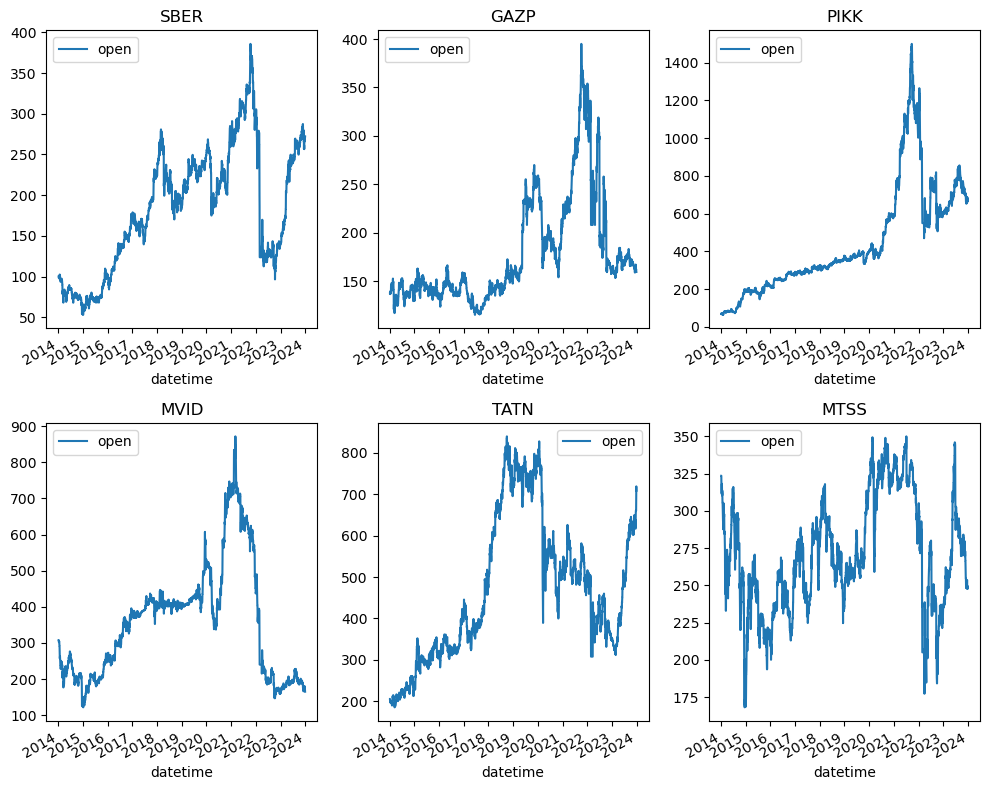

In [7]:
plot_fields(['open'])

График объема торгов

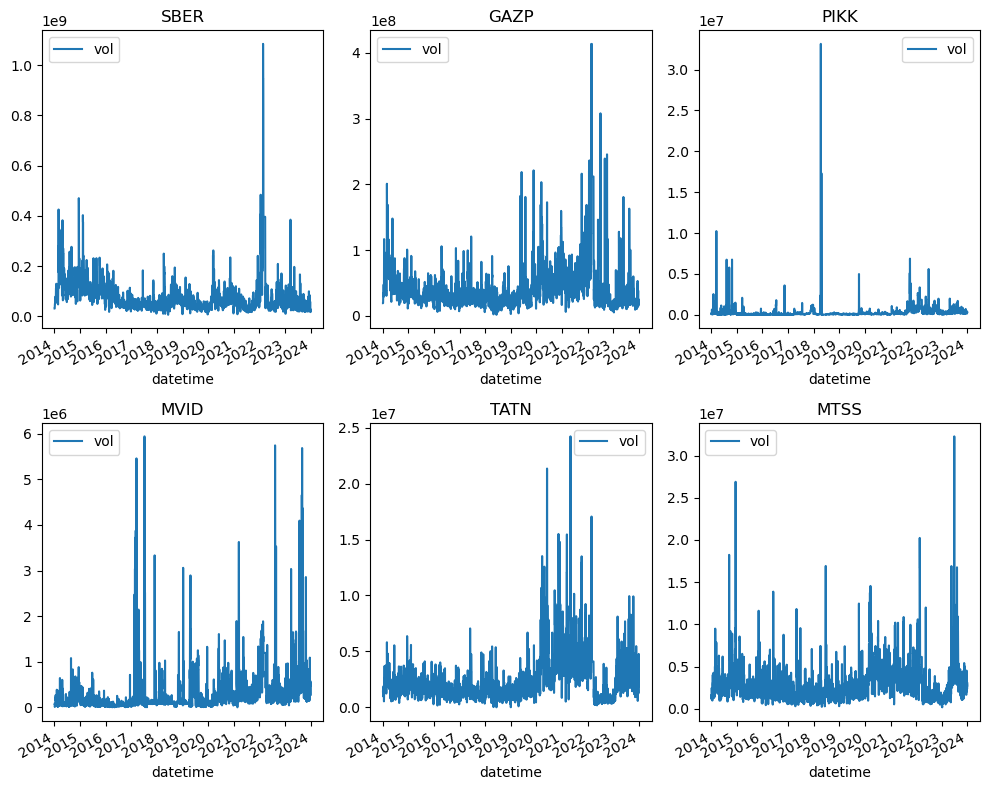

In [8]:
plot_fields(['vol'])

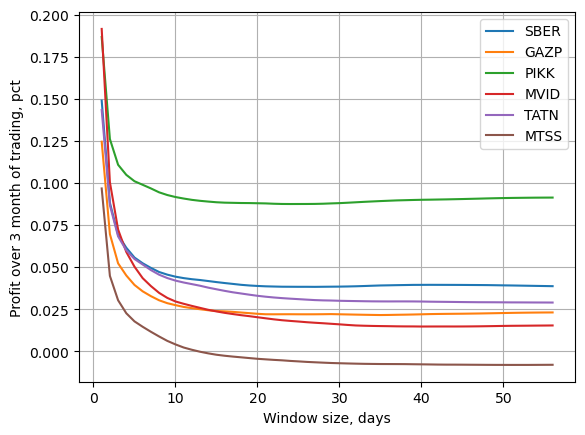

In [9]:
def explore_window_size(ticker, df):
    window_sizes = [dt.timedelta(days=i) for i in range(1, 57)]
    for w in window_sizes:
        days = w.days
        indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=days)
        df[f'max_over_{days}'] = df['high'].rolling(window=indexer).max()
        df[f'min_over_{days}'] = df['low'].rolling(window=indexer).min()
        # NOTE: min relative to high, max relative to low
        df[f'min_pct_change_over_{days}'] = (df[f'min_over_{days}'] - df['high']) / df['high']
        df[f'max_pct_change_over_{days}'] = (df[f'max_over_{days}'] - df['low']) / df['low']

    names = [f'{p}_pct_change_over_{w.days}' for w in window_sizes for p in ('max', 'min')]

    # NOTE: допустим, что ведем торги на протяжении квартала
    TRADING_DAYS = dt.timedelta(weeks=12).days
    scaled_mean_column = f'mean_scaled_to_{TRADING_DAYS}'
    desc = df[names].describe()
    desc = desc.transpose()
    desc['days'] = desc.index.str.extract('(\d+)', expand=False).astype(int)
    desc[scaled_mean_column] = desc['mean'] * TRADING_DAYS / desc['days']

    group_by_days = desc.groupby("days", group_keys=True)[[scaled_mean_column]].sum()
    return (group_by_days.index, group_by_days[scaled_mean_column])

plt.figure()
for ticker, df in dfs_daily.items():
    x, y = explore_window_size(ticker, df)
    plt.plot(x, y, label=ticker)
plt.xlabel("Window size, days")
plt.ylabel("Profit over 3 month of trading, pct")
plt.legend()
plt.grid()
plt.show()

In [10]:
%%time
dfs_minutely = {}
for ticker in TICKERS:
    dfs_minutely[ticker] = pd.read_json(get_file_name(ticker, "minutely"), lines=True)
    dfs_minutely[ticker] = dfs_minutely[ticker].sort_values(["datetime"], ascending=[True])
    dfs_minutely[ticker] = dfs_minutely[ticker].drop_duplicates(subset=['datetime'])
    dfs_minutely[ticker].set_index('datetime', inplace=True)
    dfs_minutely[ticker] = dfs_minutely[ticker].asfreq('1Min')
    dfs_minutely[ticker] = dfs_minutely[ticker].fillna(method='ffill')
    dfs_minutely[ticker]['date'] = pd.to_datetime(dfs_minutely[ticker].index.date)

CPU times: user 33.3 s, sys: 6.64 s, total: 39.9 s
Wall time: 39.9 s


In [11]:
%%time
dfs_features = {}

settings = MinimalFCParameters()

for ticker, df in dfs_minutely.items():
    dfs_features[ticker] = extract_features(
        df,
        column_id='date',
        n_jobs=10,
        default_fc_parameters=settings,
        disable_progressbar=True
    )
    impute(dfs_features[ticker])


CPU times: user 23.7 s, sys: 3.39 s, total: 27.1 s
Wall time: 29.7 s


In [12]:
metrics = {}
models = {}
splits = {}

def train(ticker, target_window_days, kind, threshold):
    kind_column_name = f'{kind}_over_{target_window_days}'
    kind_pct_column_name = f'{kind}_pct_change_over_{target_window_days}'

    df_daily = dfs_daily[ticker]
    if kind == "min":
        target = df_daily[kind_pct_column_name] <= threshold
    elif kind == "max":
        target = df_daily[kind_pct_column_name] >= threshold

    extracted_features = dfs_features[ticker]
    # extracted_features.info()
    features_filtered = select_features(extracted_features, target)
    # print(features_filtered.info())
    # features_filtered.info()

    X_train, X_test, y_train, y_test = train_test_split(
        features_filtered,
        target,
        test_size=0.33,
        shuffle=False
    )
    splits[(ticker, target_window_days, kind, threshold)] = (X_train, X_test, y_train, y_test)
    param_grid = {
        "learning_rate": [0.01, 0.05, 0.1],
        "n_estimators": [10, 20, 40, 50, 100]
    }
    estimator = lgb.LGBMRegressor(
        num_leaves=31,
        verbosity=-1
    )

    gs = GridSearchCV(
        estimator,
        param_grid,
        scoring=['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'],
        cv=3,
        refit='neg_root_mean_squared_error'
    )
    gs.fit(X_train, y_train)

    model = gs.best_estimator_
    models[(ticker, target_window_days, kind, threshold)] = model
    
    y_pred = model.predict(X_test)
    metrics[(ticker, target_window_days, kind, threshold)] = {
        "mse": mean_squared_error(y_test, y_pred),
        "rmse": root_mean_squared_error(y_test, y_pred),
        "mae": mean_absolute_error(y_test, y_pred),
        "roc-auc-score": roc_auc_score(y_test, y_pred),
    }

In [13]:
def get_thresholds(ticker, kind, window_size):
    df = dfs_daily[ticker]
    desc = df[f'{kind}_pct_change_over_{window_size}'].describe() 
    desc = desc[['mean', '25%', '50%', '75%']]
    return desc.values

In [14]:
params = []
for ticker in TICKERS:
    for window_days in [3, 5, 7]:
        for kind in ['min', 'max']:
            for threshold in get_thresholds(ticker, kind, window_days):
                params.append((ticker, window_days, kind, threshold))

In [15]:
%%time
for p in params:
    ticker, window_days, kind, threshold = p
    print(f"Train model {ticker=}, {window_days=}, {kind=}, {threshold=}")
    train(ticker, window_days, kind, threshold)

Train model ticker='SBER', window_days=3, kind='min', threshold=-0.03516963136909239
Train model ticker='SBER', window_days=3, kind='min', threshold=-0.03882408239773324
Train model ticker='SBER', window_days=3, kind='min', threshold=-0.026298462372671257
Train model ticker='SBER', window_days=3, kind='min', threshold=-0.018043553404770228
Train model ticker='SBER', window_days=3, kind='max', threshold=0.03763855201314583
Train model ticker='SBER', window_days=3, kind='max', threshold=0.01954057191227354
Train model ticker='SBER', window_days=3, kind='max', threshold=0.0283783783783783
Train model ticker='SBER', window_days=3, kind='max', threshold=0.0429815016322088
Train model ticker='SBER', window_days=5, kind='min', threshold=-0.04128691630000558
Train model ticker='SBER', window_days=5, kind='min', threshold=-0.04708044676940475
Train model ticker='SBER', window_days=5, kind='min', threshold=-0.03028311425682512
Train model ticker='SBER', window_days=5, kind='min', threshold=-0.02

In [16]:
def sensivity_specifity_cutoff(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    idx = np.argmax(tpr - fpr)
    return thresholds[idx]

def check(p_min, p_max):
    max_X_train, max_X_test, max_y_train, max_y_test = splits[p_max]
    max_model = models[p_max]

    max_y_pred = max_model.predict(max_X_test)
    max_cutoff = sensivity_specifity_cutoff(max_y_test, max_y_pred)
    
    min_X_train, min_X_test, min_y_train, min_y_test = splits[p_min]
    min_model = models[p_min]

    min_y_pred = min_model.predict(min_X_test)
    min_cutoff = sensivity_specifity_cutoff(min_y_test, min_y_pred)

    ticker = p_max[0]
    daily = dfs_daily[ticker]
    df = max_X_test.copy()
    df['max_predict'] = max_y_pred
    df['min_predict'] = min_y_pred

    initial_balance = 1_000_000 
    balance = initial_balance
    amount = 0
    balances = []
    amounts = []
    stock_prices = []
    for index, row in df.iterrows():
        stock_price = daily[daily.index.isin([index])].close[0]

        if row['max_predict'] >= max_cutoff and row['min_predict'] < min_cutoff:
            if amount == 0:
                amount = balance // stock_price
                purchase_price = amount * stock_price
                balance = balance - purchase_price
                # print(f"BUY {amount=}, {purchase_price=}, {balance=}")
            else:
                ...
                # print("HOLD")    
        elif row['min_predict'] >= min_cutoff and row['max_predict'] < max_cutoff:
            if amount == 0:
                ...
                # print("NOTHING TO SELL")
            else:
                sale_price = amount * stock_price
                amount = 0
                balance = balance + sale_price
                # print(f"SELL {amount=}, {sale_price=}, {balance=}")
        balances.append(balance)
        amounts.append(amount)
        stock_prices.append(stock_price)
    if amount != 0:
        sale_price = amount * stock_price
        amount = 0
        balance = balance + sale_price

    df['balance'] = balances
    df['amount'] = amounts
    df['stock_price'] = stock_prices
    
    balance_pct_change = (balance - initial_balance) / initial_balance
    return balance_pct_change, df

Найдем наиболее прибыльные комбинации window_size, min_threshold и max_threshold для каждой бумаги

In [17]:
%%time
params_g = {}
for p in params:
    ticker, window_days, kind, threshold = p
    key = (ticker, window_days)

    if key not in params_g:
        params_g[key] = {"min": [], "max": []}
    params_g[key][kind].append(threshold)

prod_pct_changes = {}
prod_dfs = {}

for key, value in params_g.items():
    ticker, window_days = key
    mins = value["min"]
    maxs = value["max"]

    for min_threshold in mins:
        for max_threshold in maxs:
            p_min = (ticker, window_days, "min", min_threshold)
            p_max = (ticker, window_days, "max", max_threshold)
            pct_change, df = check(p_min, p_max)
            prod_pct_changes[(ticker, window_days, (min_threshold, max_threshold))] = pct_change
            prod_dfs[(ticker, window_days, (min_threshold, max_threshold))] = df

CPU times: user 16min 51s, sys: 3.53 s, total: 16min 54s
Wall time: 14min 57s


In [18]:
for k, v in prod_pct_changes.items():
    print(k, v)

('SBER', 3, (-0.03516963136909239, 0.03763855201314583)) 1.70808809
('SBER', 3, (-0.03516963136909239, 0.01954057191227354)) 0.18783127000000024
('SBER', 3, (-0.03516963136909239, 0.0283783783783783)) 0.9574449899999993
('SBER', 3, (-0.03516963136909239, 0.0429815016322088)) 1.671867629999999
('SBER', 3, (-0.03882408239773324, 0.03763855201314583)) 1.289768509999999
('SBER', 3, (-0.03882408239773324, 0.01954057191227354)) 1.2067727399999997
('SBER', 3, (-0.03882408239773324, 0.0283783783783783)) 0.8225138200000005
('SBER', 3, (-0.03882408239773324, 0.0429815016322088)) 1.313364709999999
('SBER', 3, (-0.026298462372671257, 0.03763855201314583)) 0.20148973999999883
('SBER', 3, (-0.026298462372671257, 0.01954057191227354)) 0.14827047999999976
('SBER', 3, (-0.026298462372671257, 0.0283783783783783)) -0.21111884999999997
('SBER', 3, (-0.026298462372671257, 0.0429815016322088)) -0.133071570000001
('SBER', 3, (-0.018043553404770228, 0.03763855201314583)) 1.4018214299999987
('SBER', 3, (-0.018

In [19]:
best_models_p = {}
for key, pct_change in dict(sorted(prod_pct_changes.items(), key=lambda item: -item[1])).items():
    ticker, window_days, thresholds = key
    min_threshold, max_threshold = thresholds

    if ticker not in best_models_p:
        print(f"{ticker=} {window_days=} {min_threshold=} {max_threshold=} {pct_change=}")
        best_models_p[ticker] = (window_days, min_threshold, max_threshold)

ticker='SBER' window_days=3 min_threshold=-0.03516963136909239 max_threshold=0.03763855201314583 pct_change=1.70808809
ticker='PIKK' window_days=5 min_threshold=-0.04260180760830446 max_threshold=0.033707865168539325 pct_change=1.6195294999999996
ticker='TATN' window_days=5 min_threshold=-0.05050847457627111 max_threshold=0.023854961832061067 pct_change=1.5433241999999998
ticker='GAZP' window_days=3 min_threshold=-0.023695652173913118 max_threshold=0.03571032038968233 pct_change=1.3092544899999994
ticker='MTSS' window_days=5 min_threshold=-0.026718146718146648 max_threshold=0.027722772277227723 pct_change=0.6280060999999999
ticker='MVID' window_days=5 min_threshold=-0.02009456264775414 max_threshold=0.04852506570768564 pct_change=0.2563065999999996


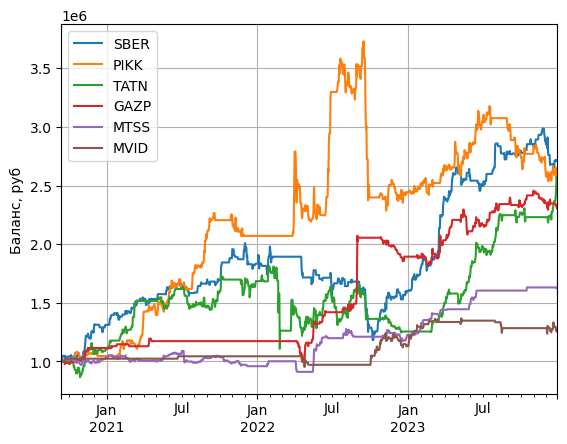

In [20]:
plt.figure()

for ticker, p in best_models_p.items():
    window_days, min_threshold, max_threshold = p
    key = (ticker, window_days, (min_threshold, max_threshold)) 
    prod_dfs[key]['balance_with_stocks'] = prod_dfs[key]['balance'] + (prod_dfs[key]['amount'] * prod_dfs[key]['stock_price']) 
    prod_dfs[key]['balance_with_stocks'].plot(label=ticker)
plt.ylabel("Баланс, руб")
plt.legend()
plt.grid()
plt.show()

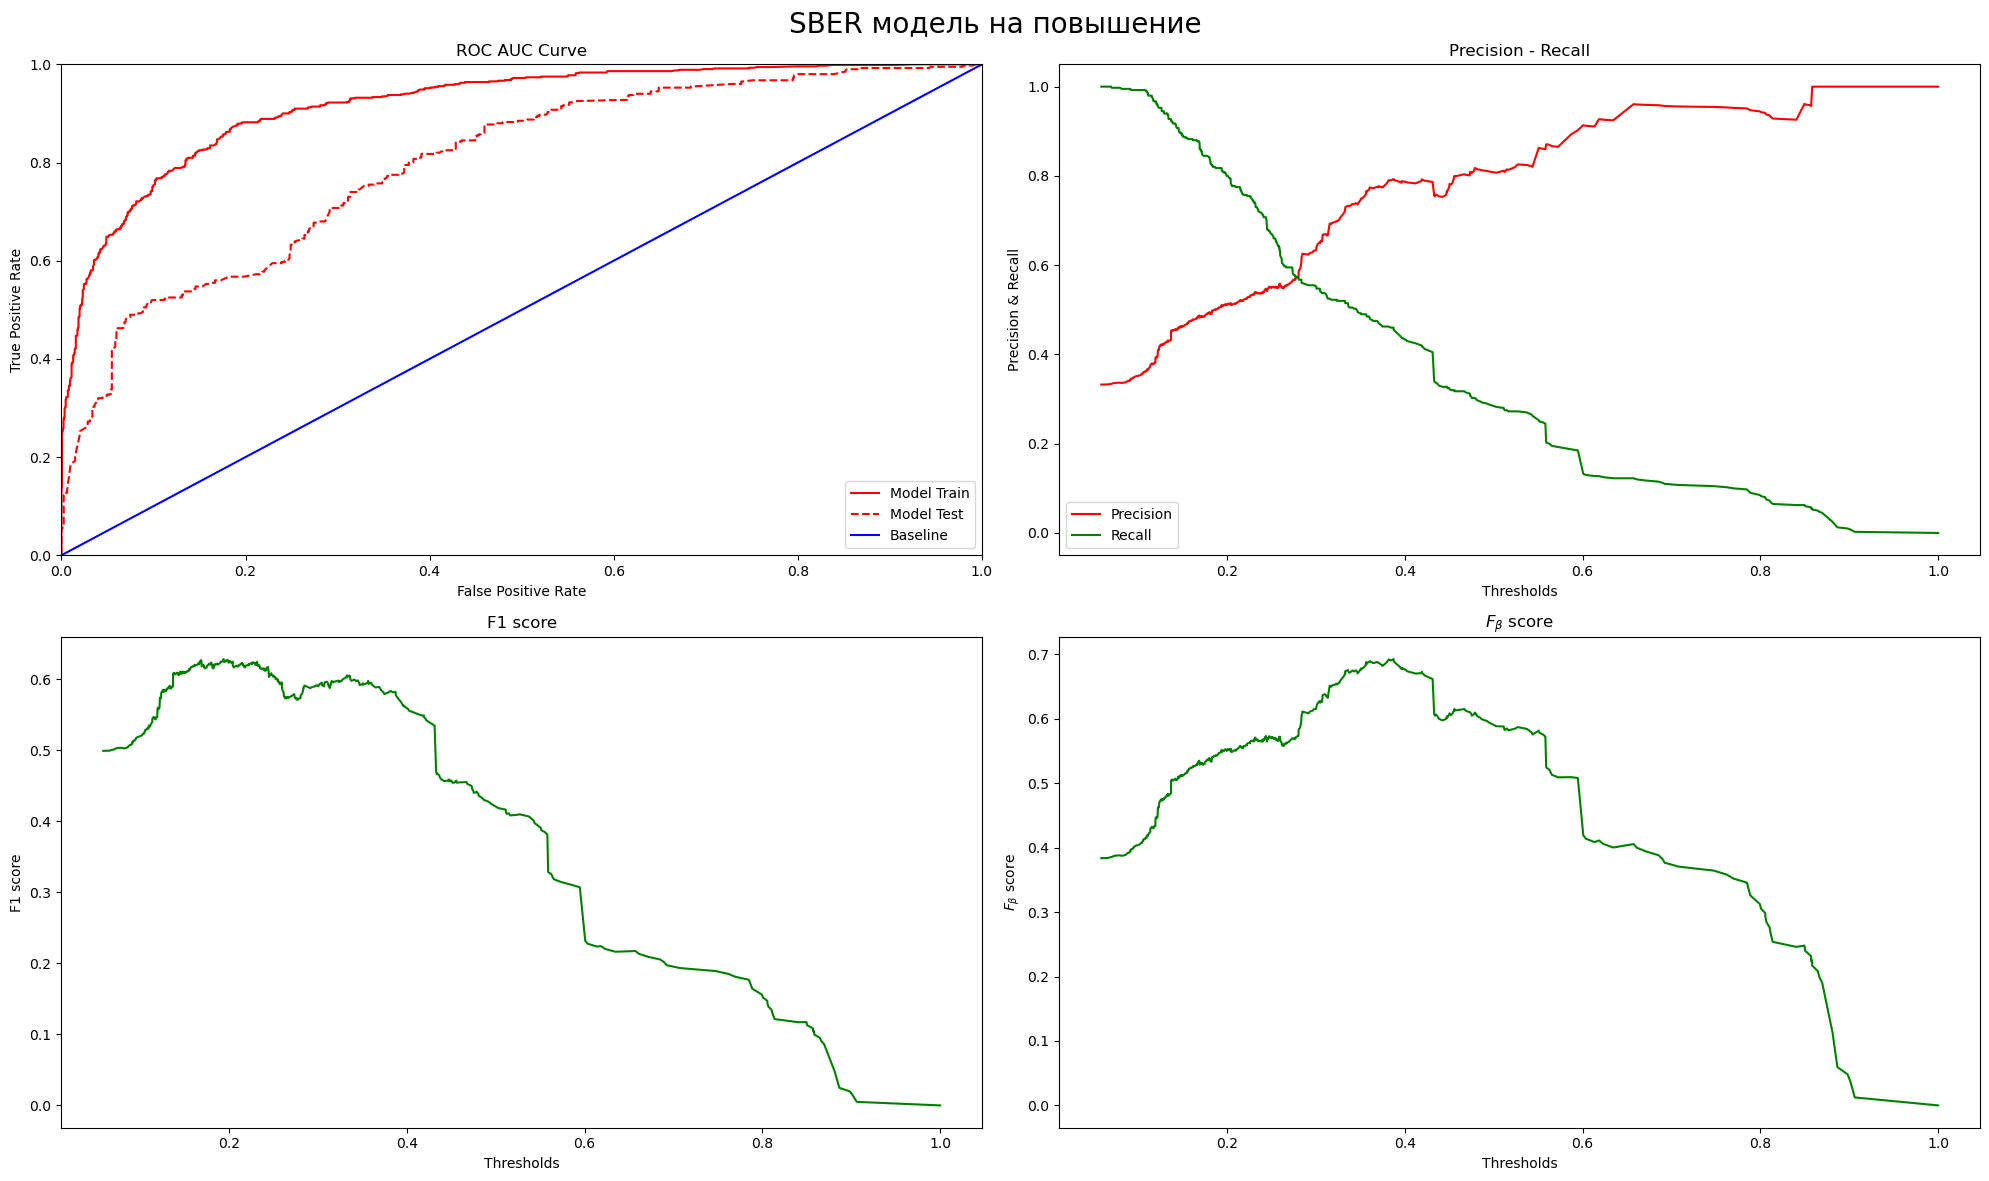

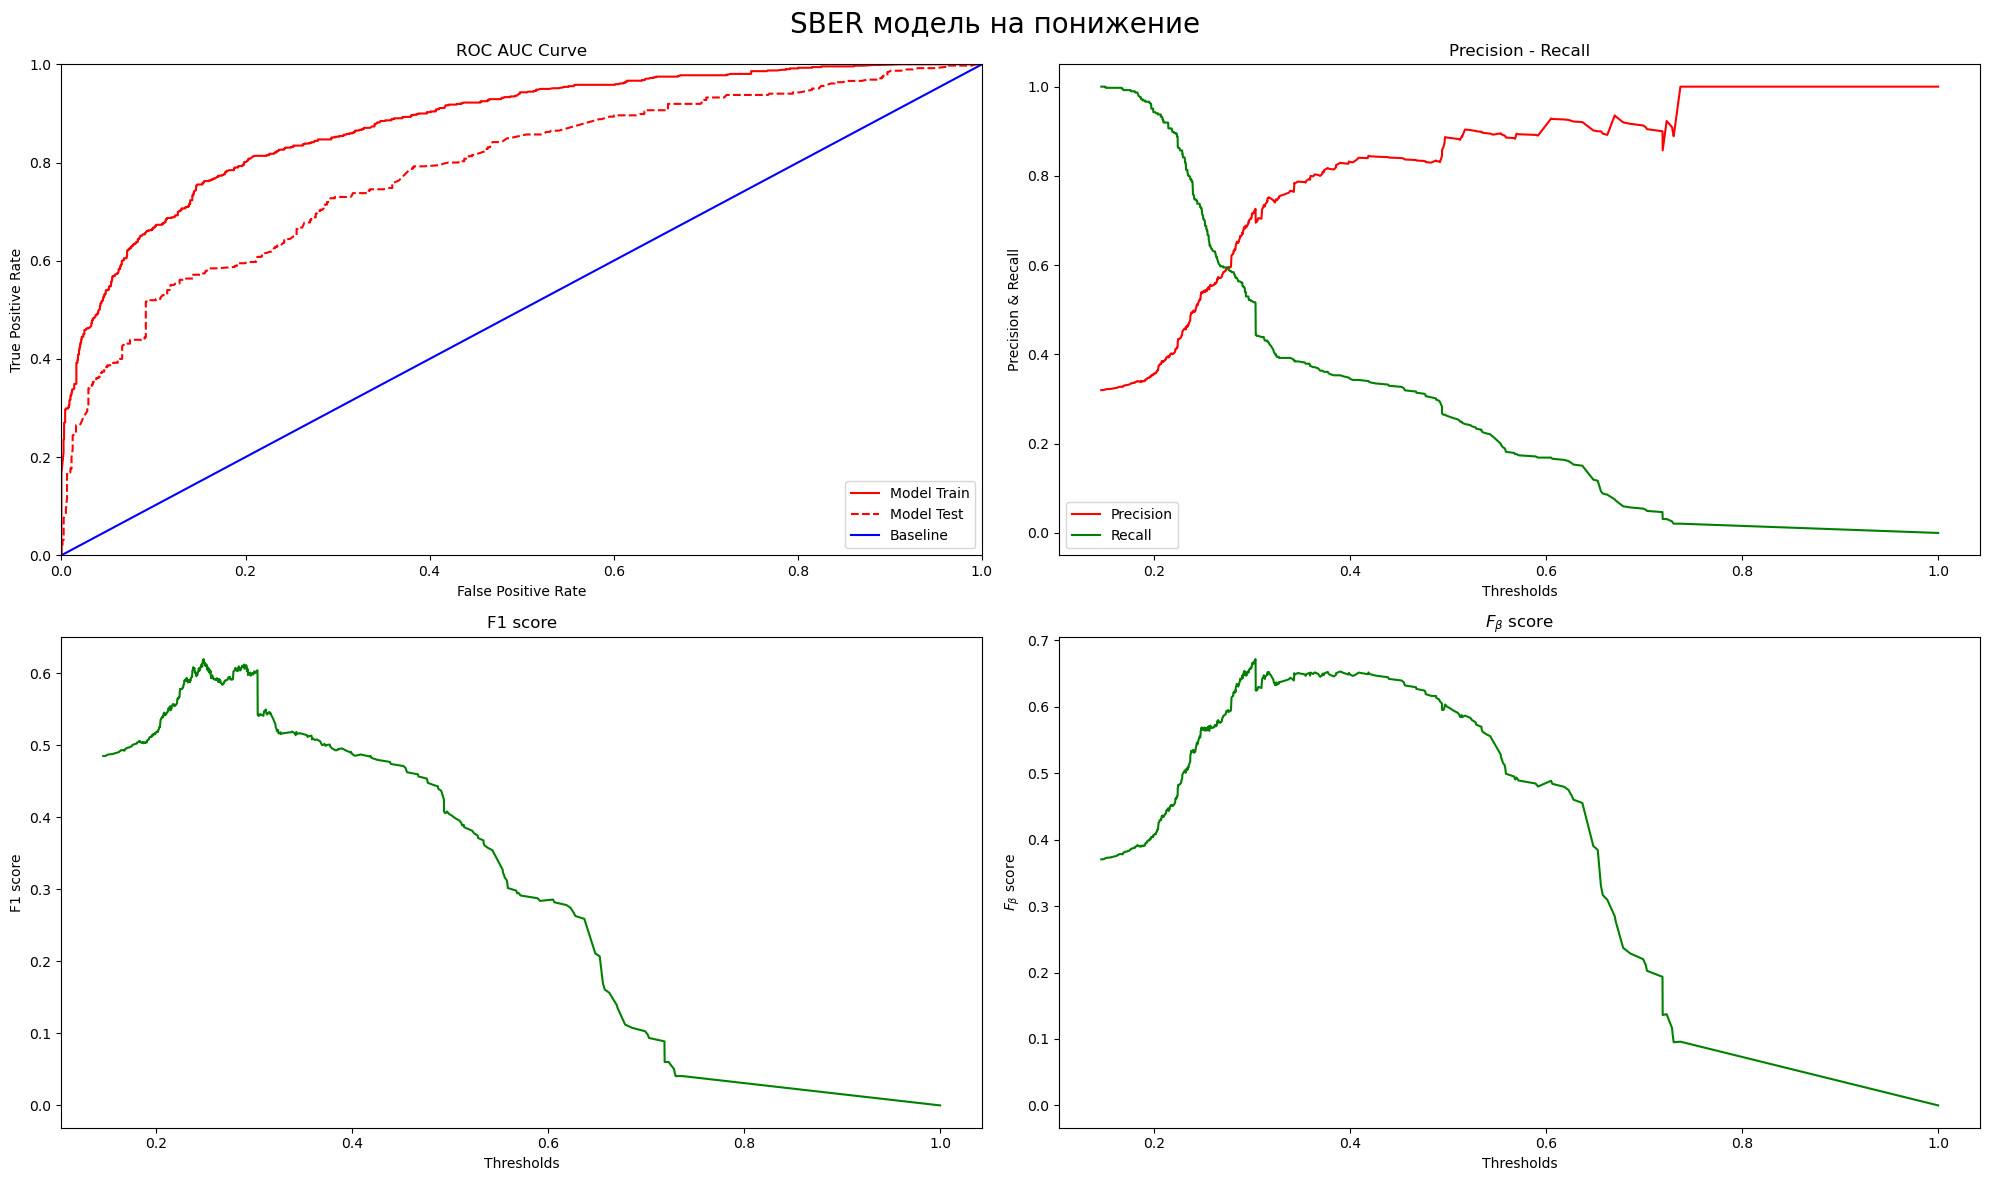

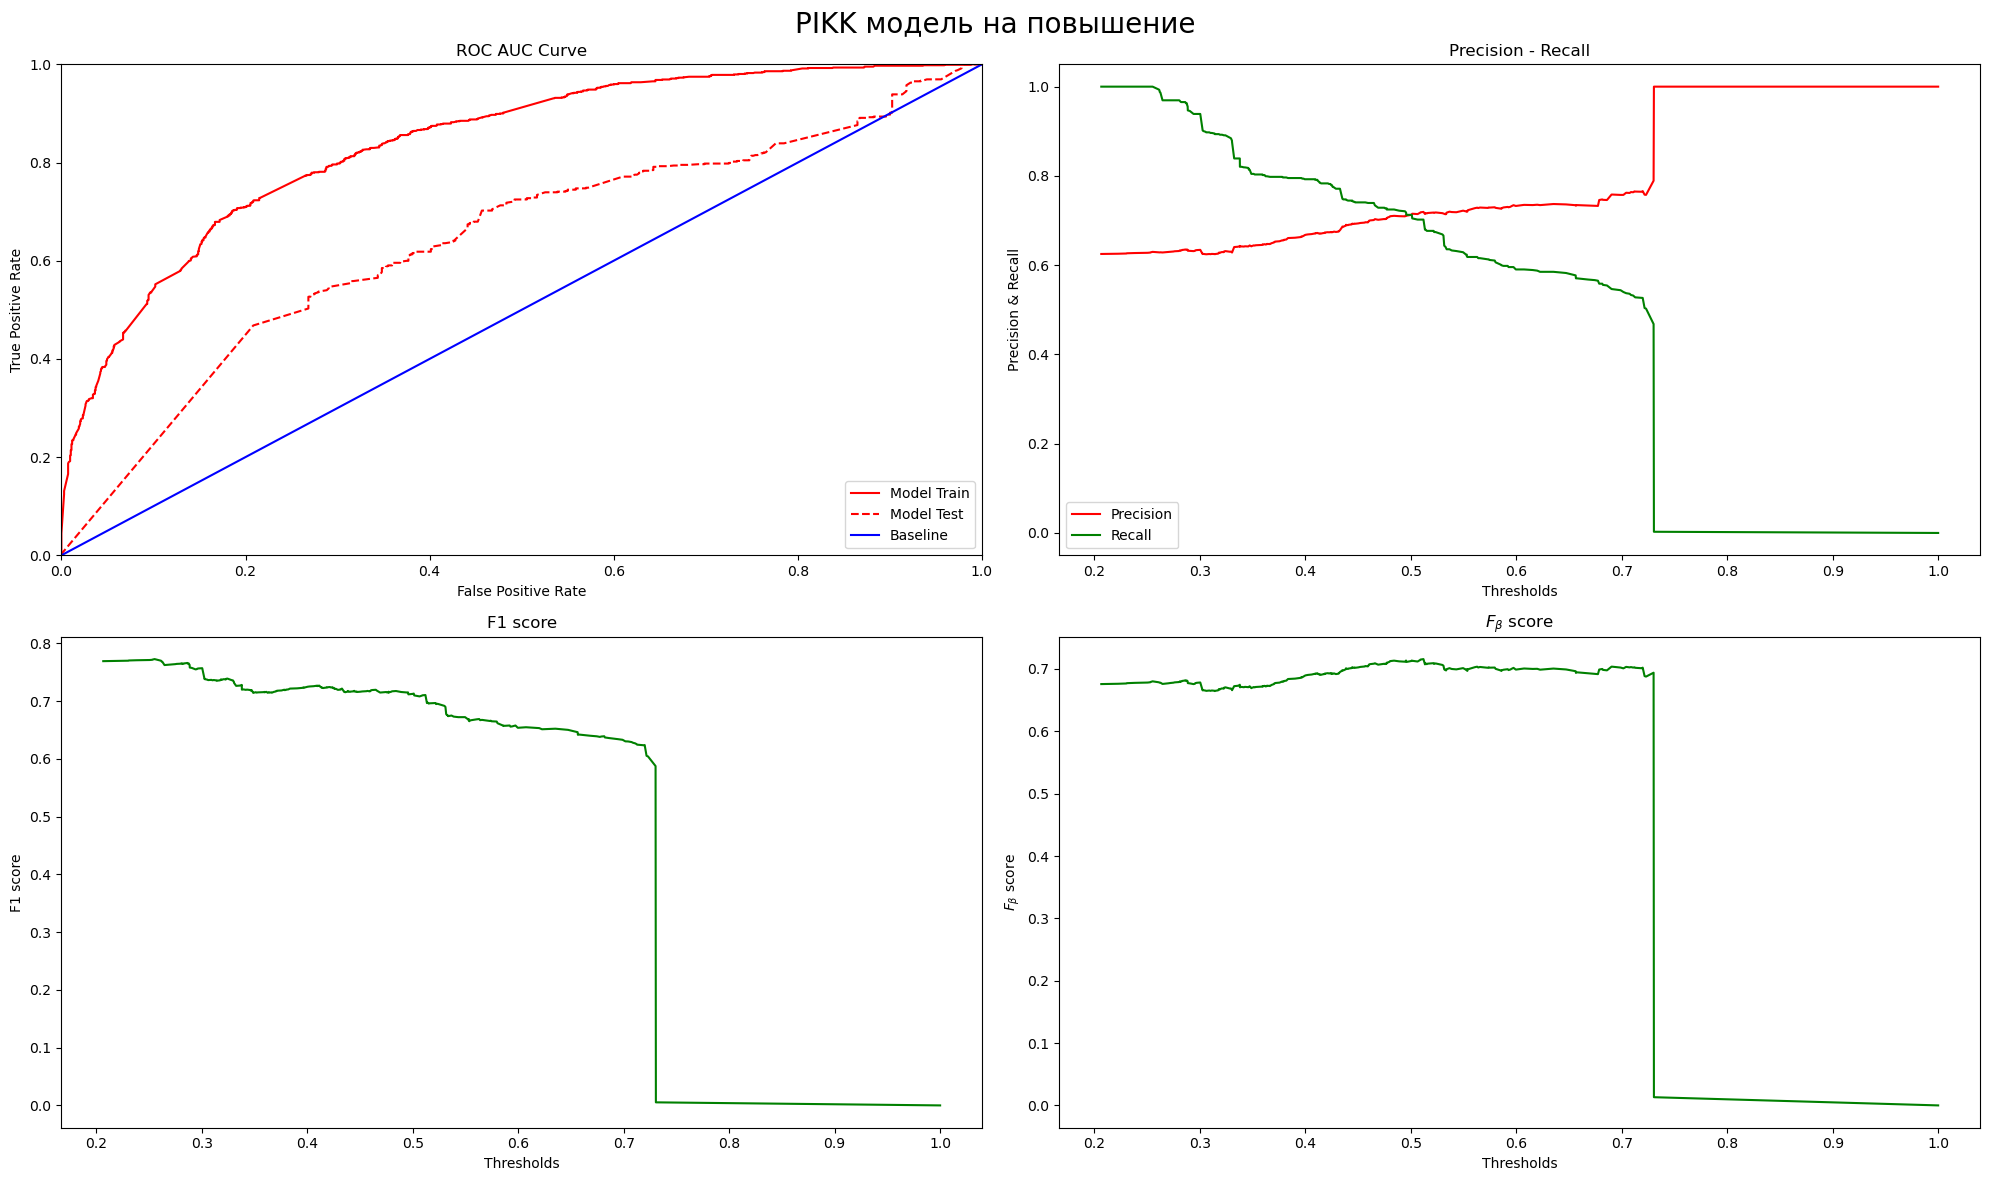

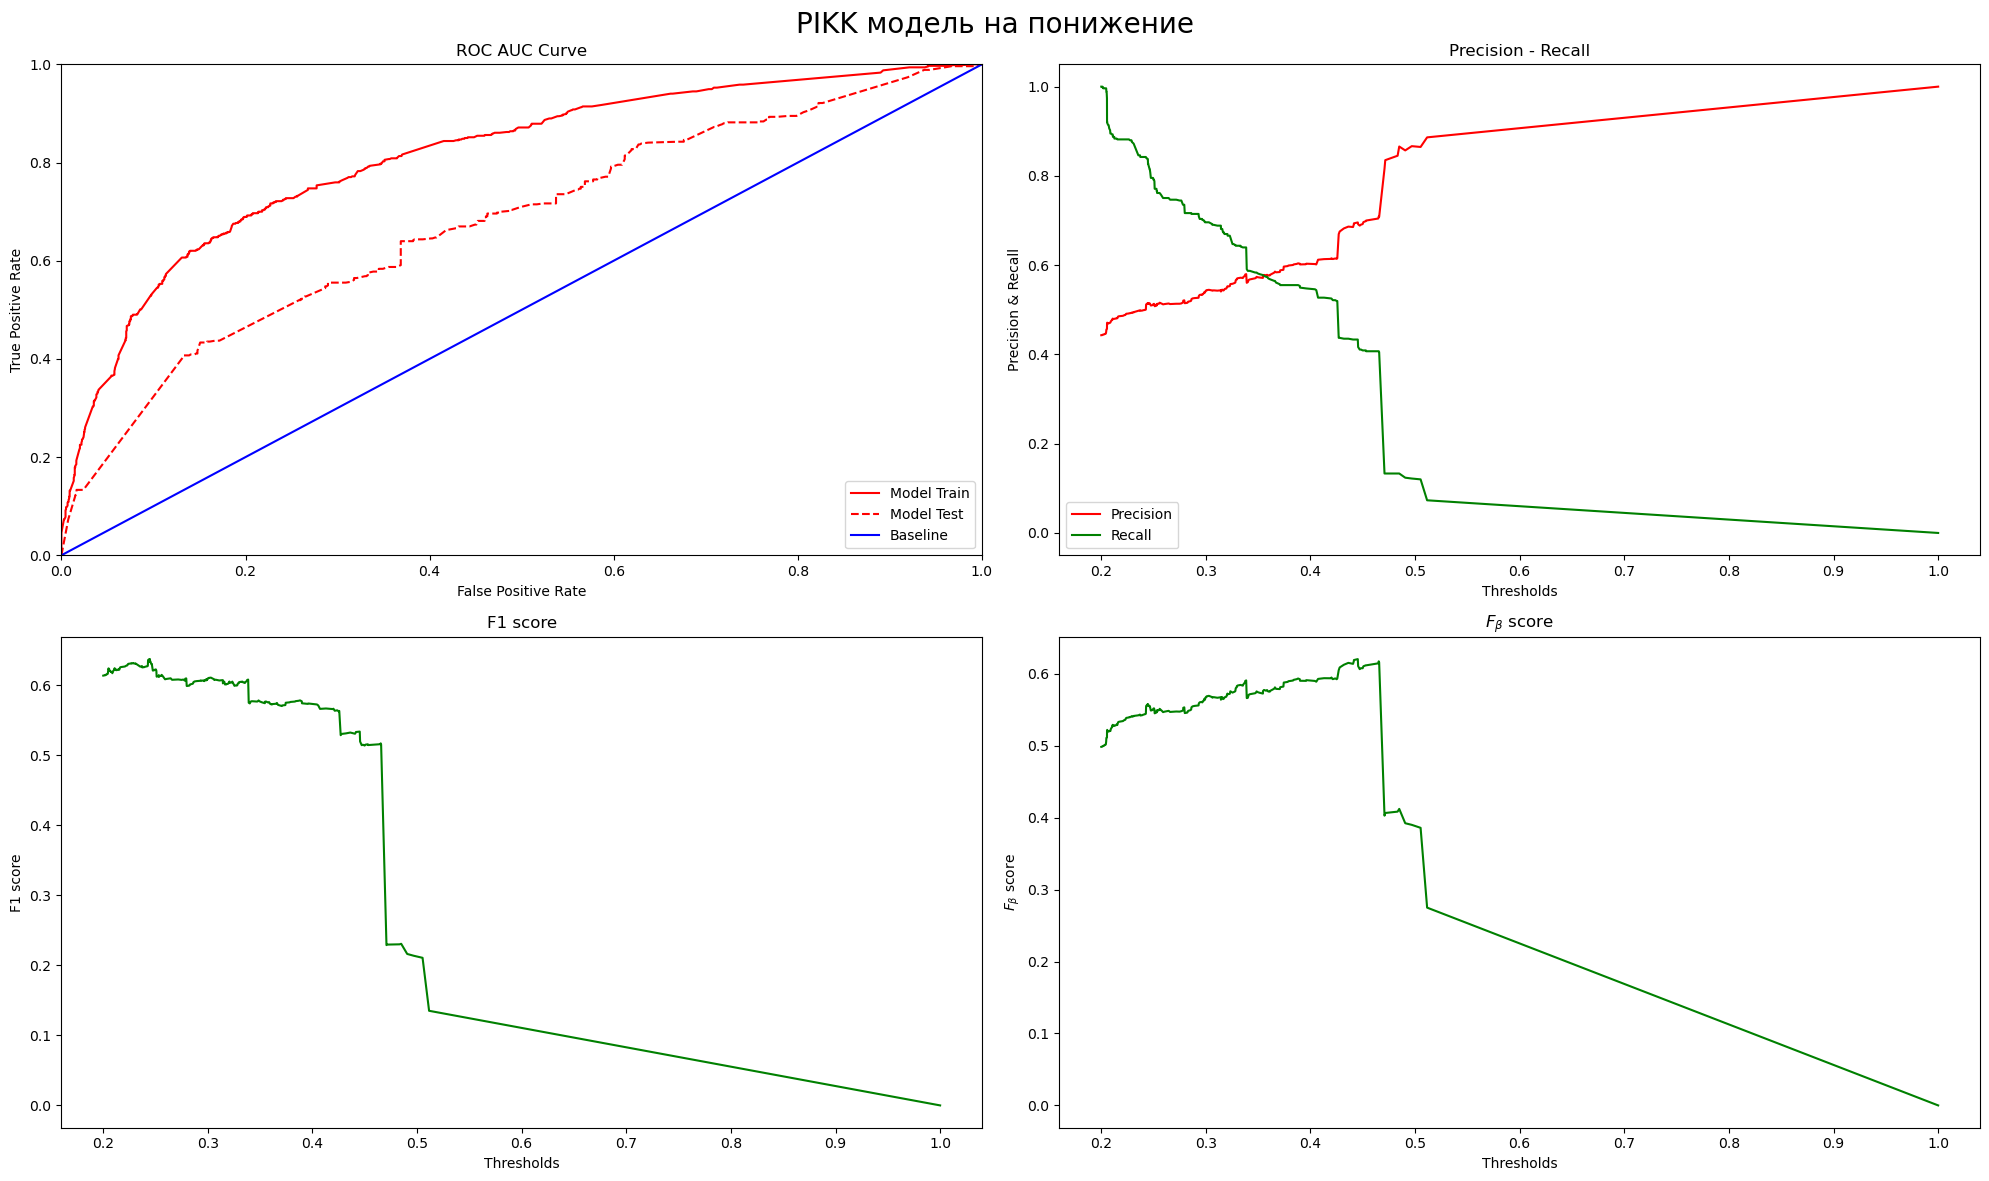

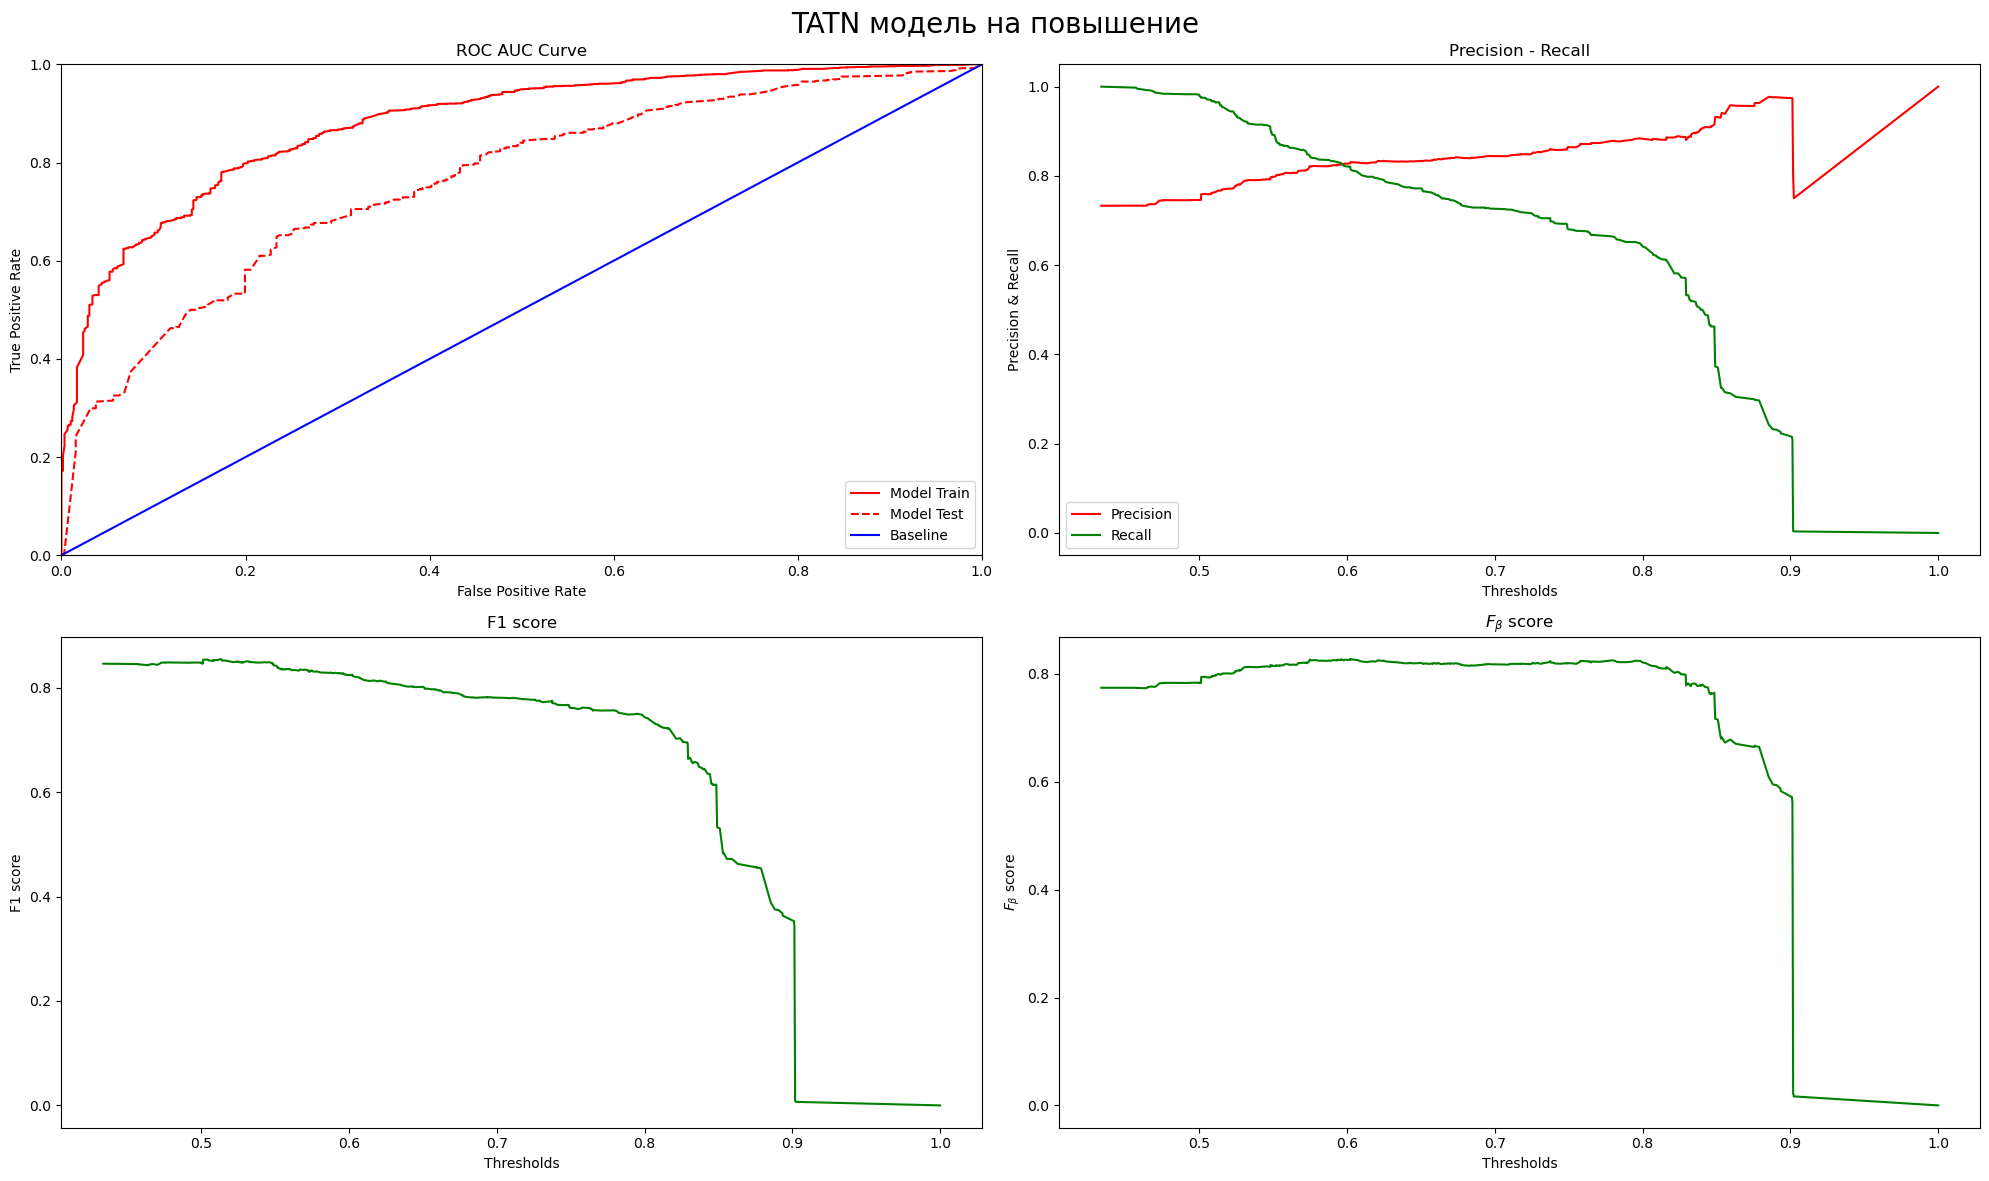

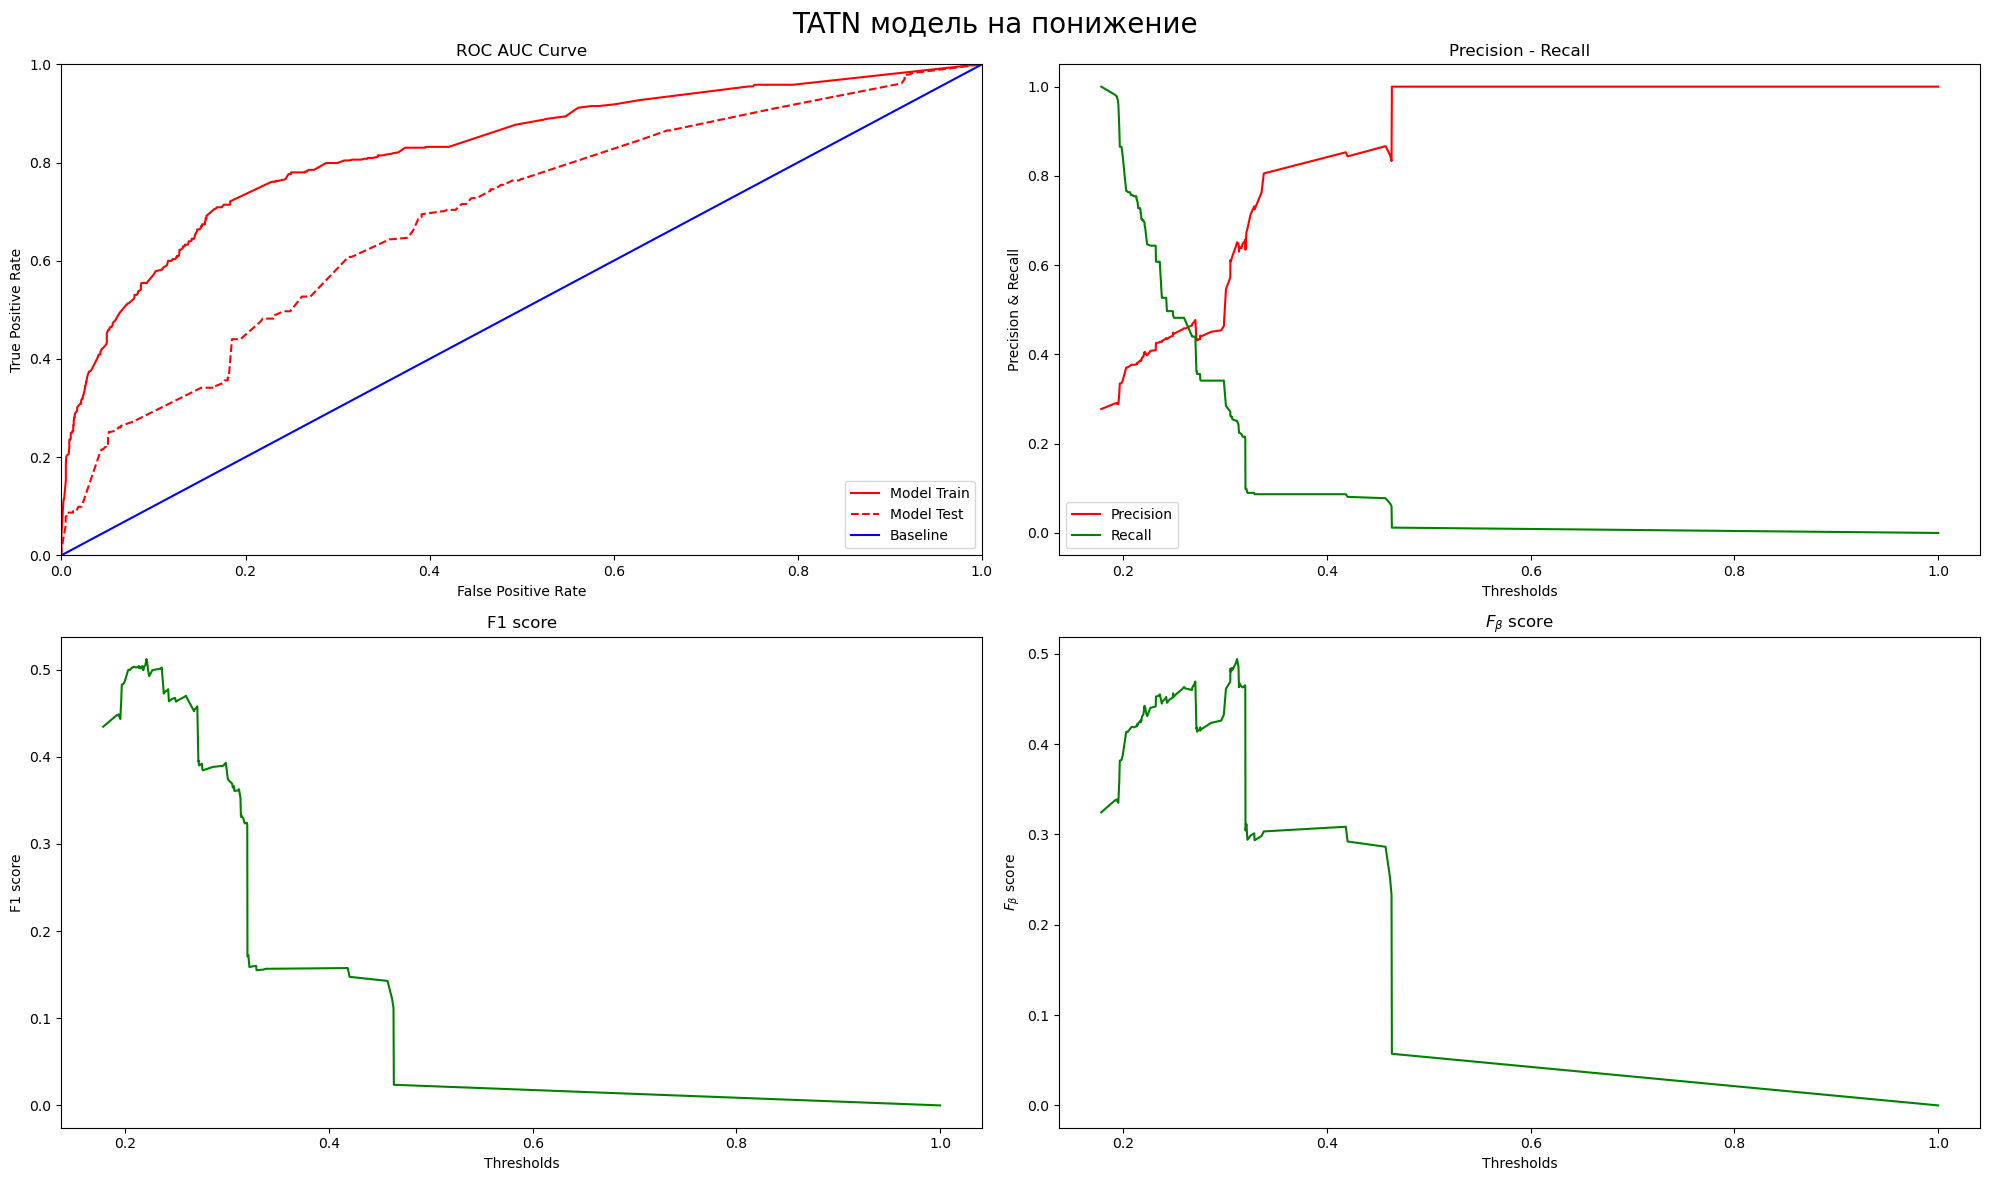

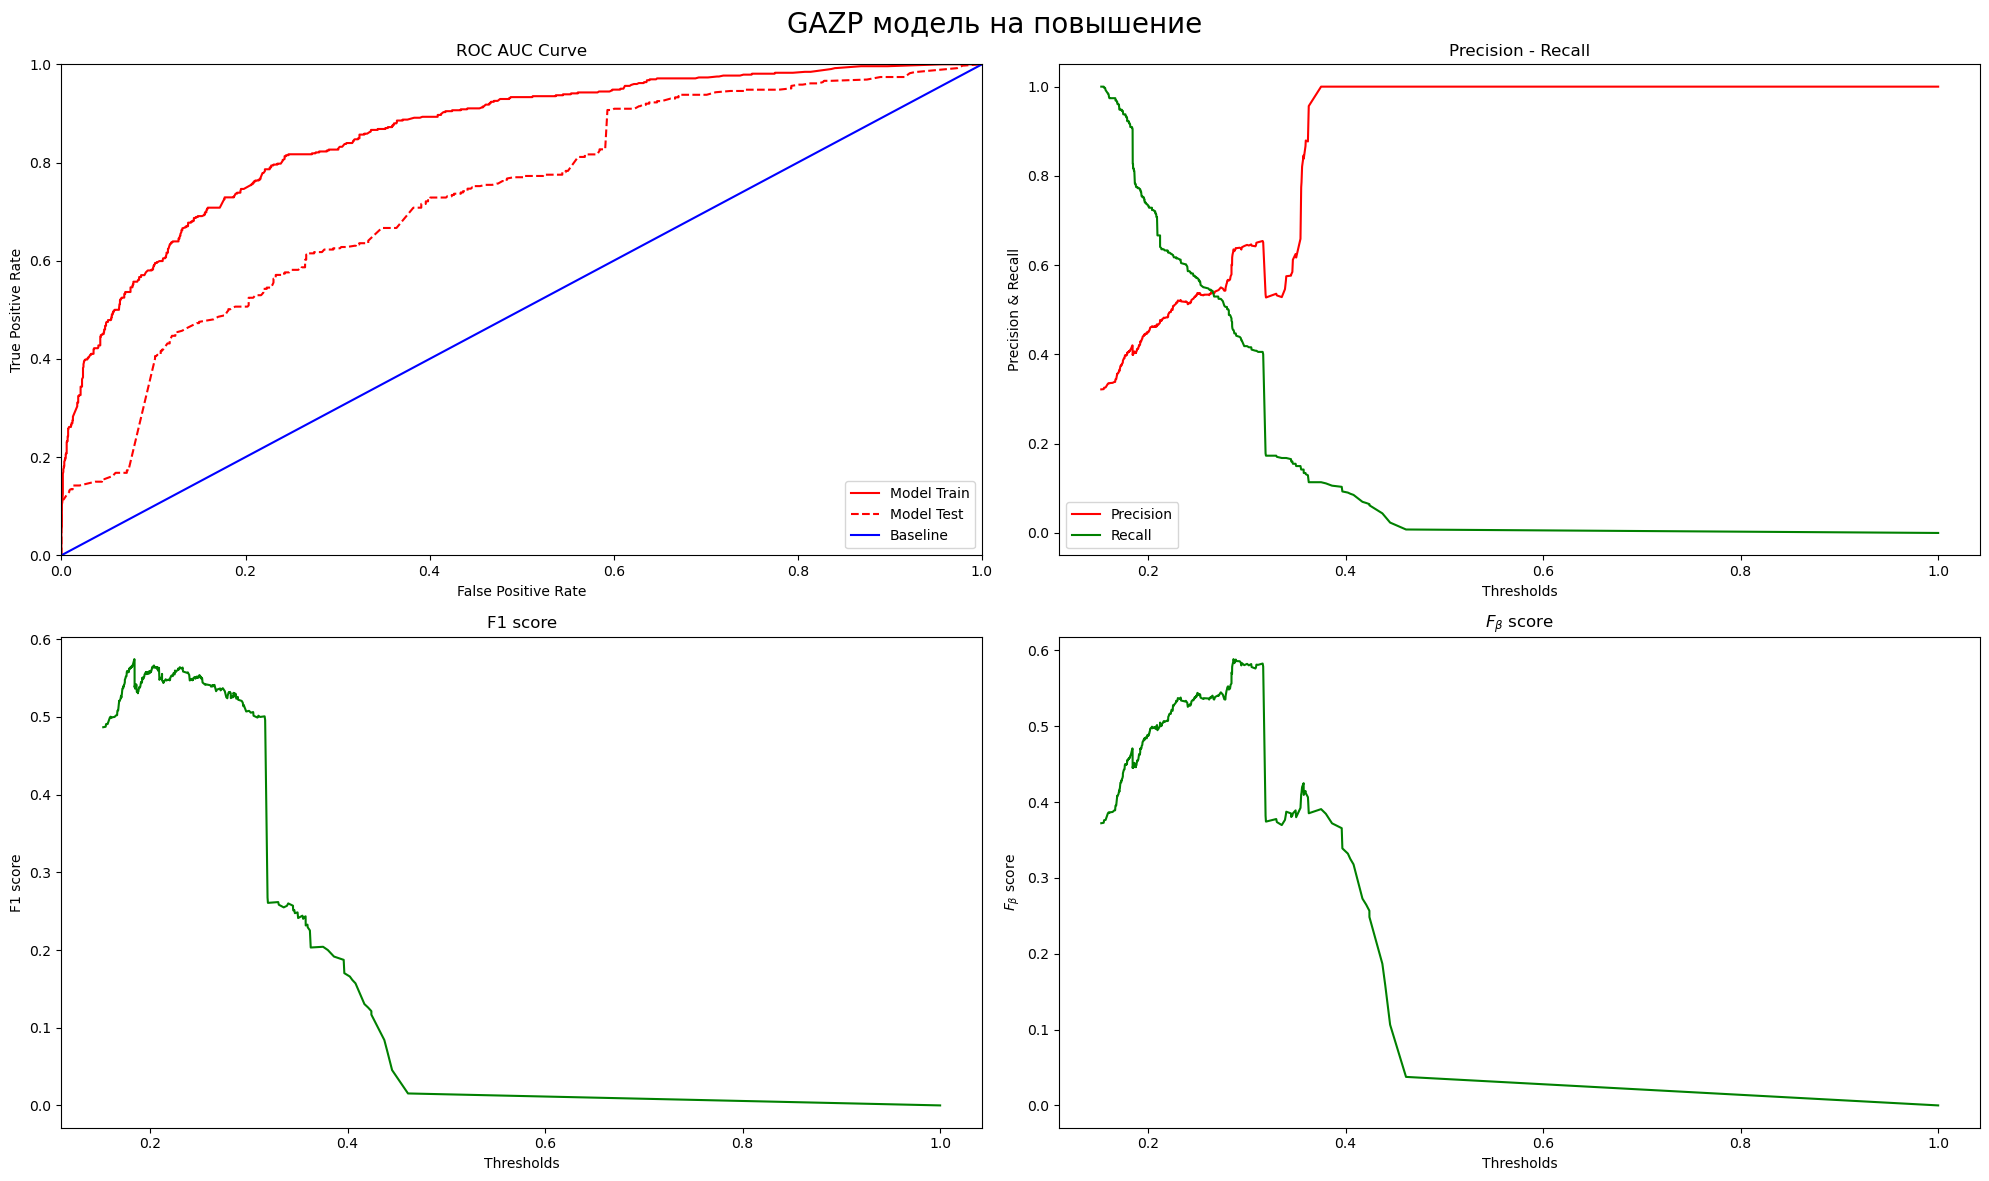

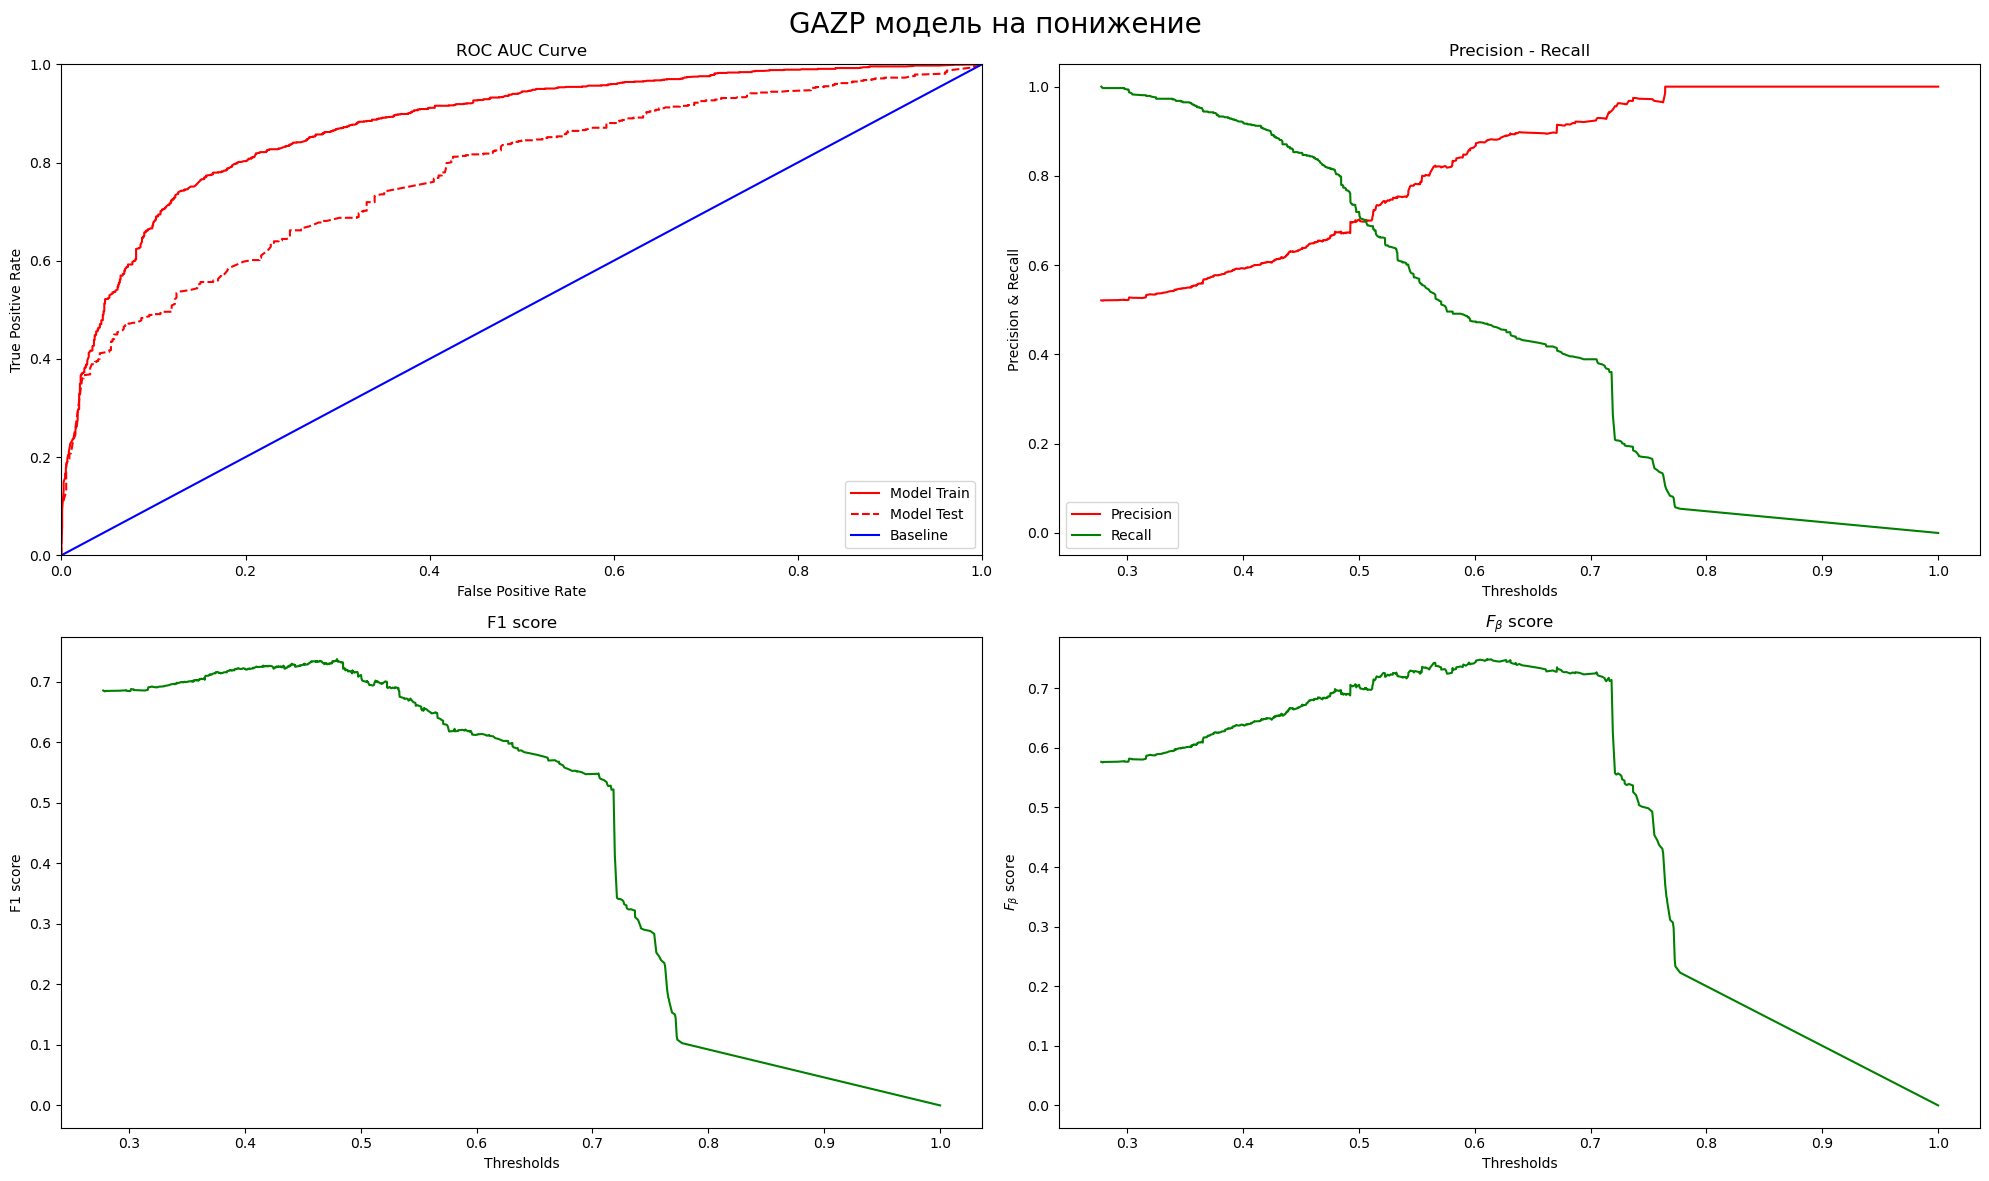

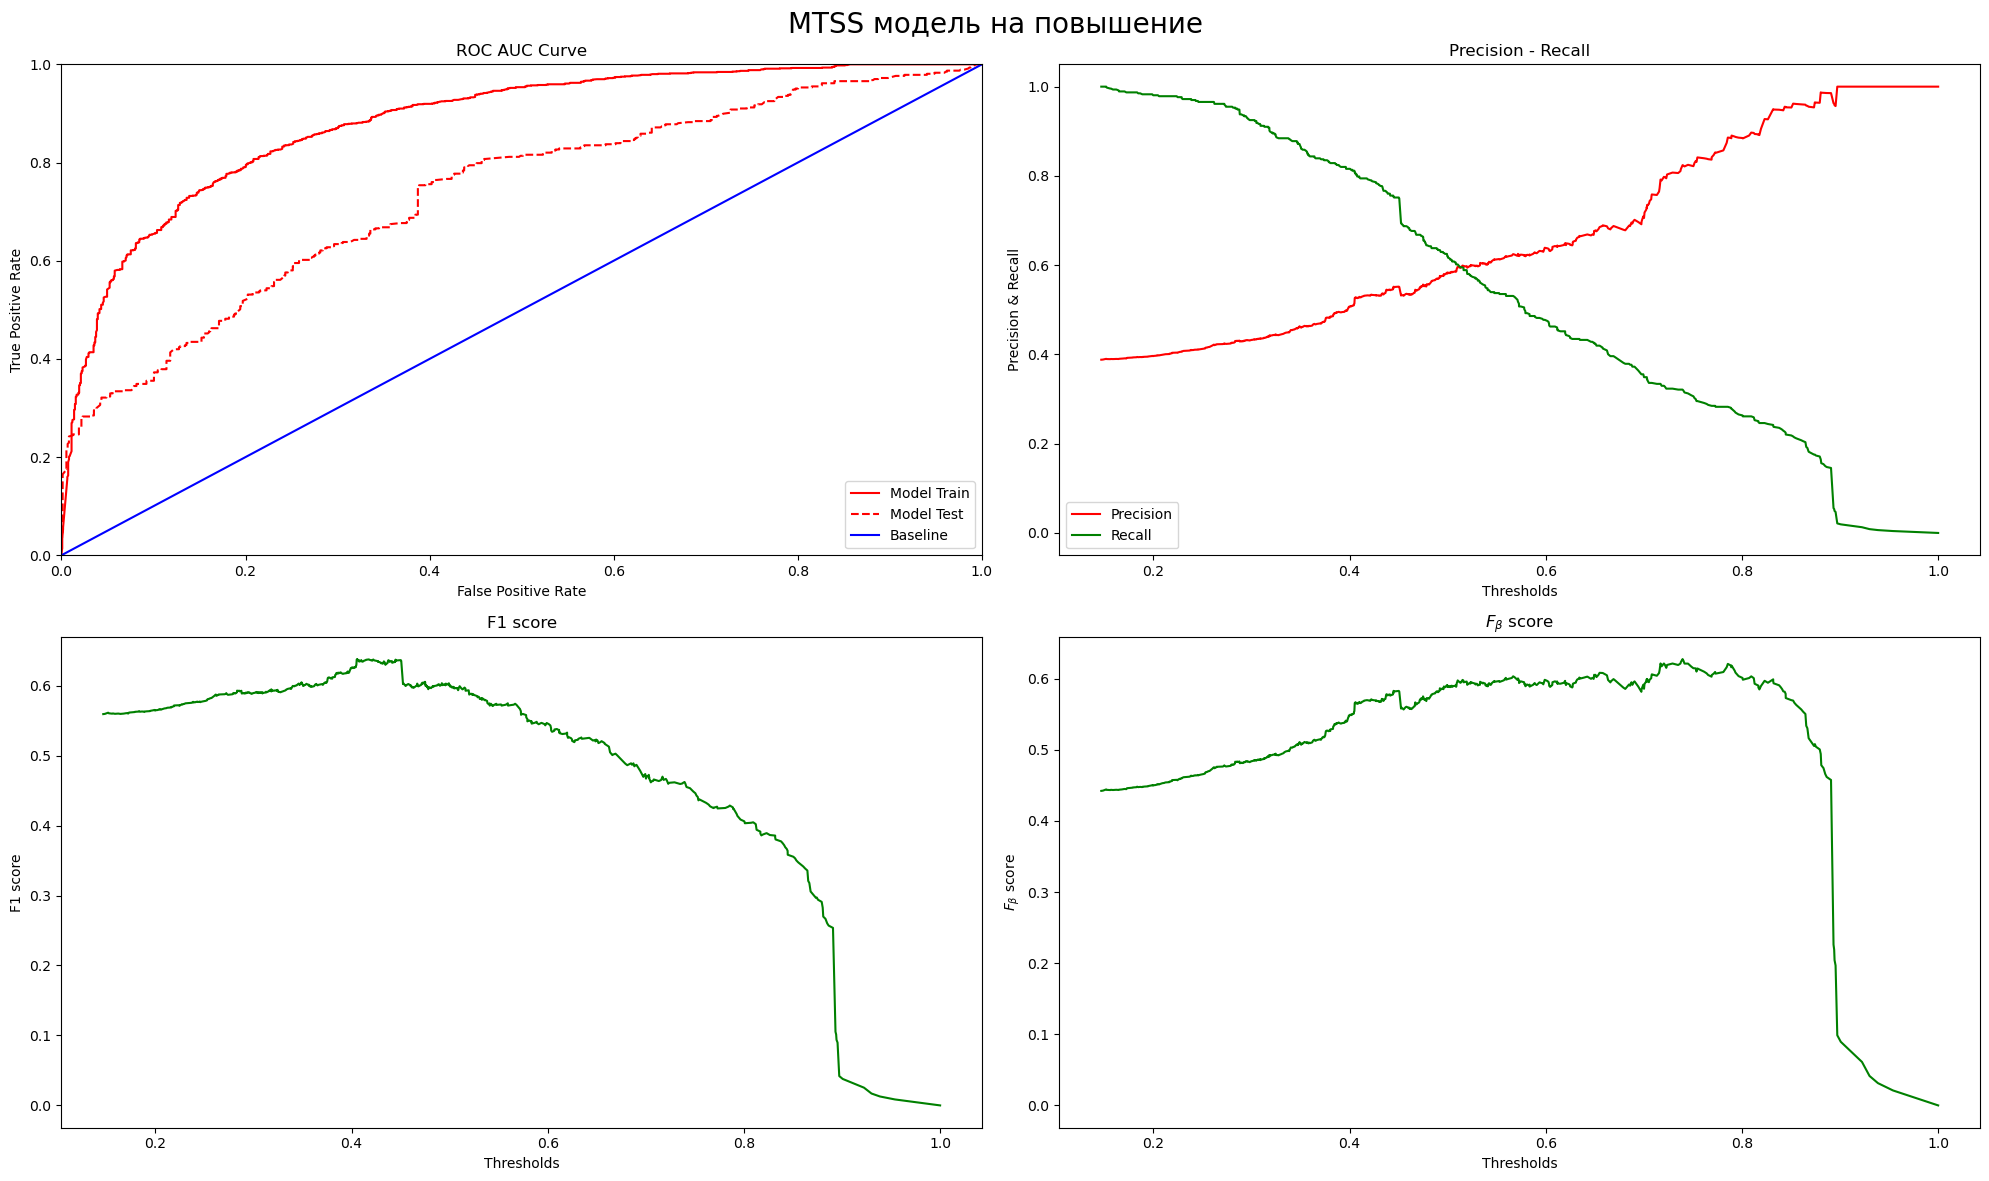

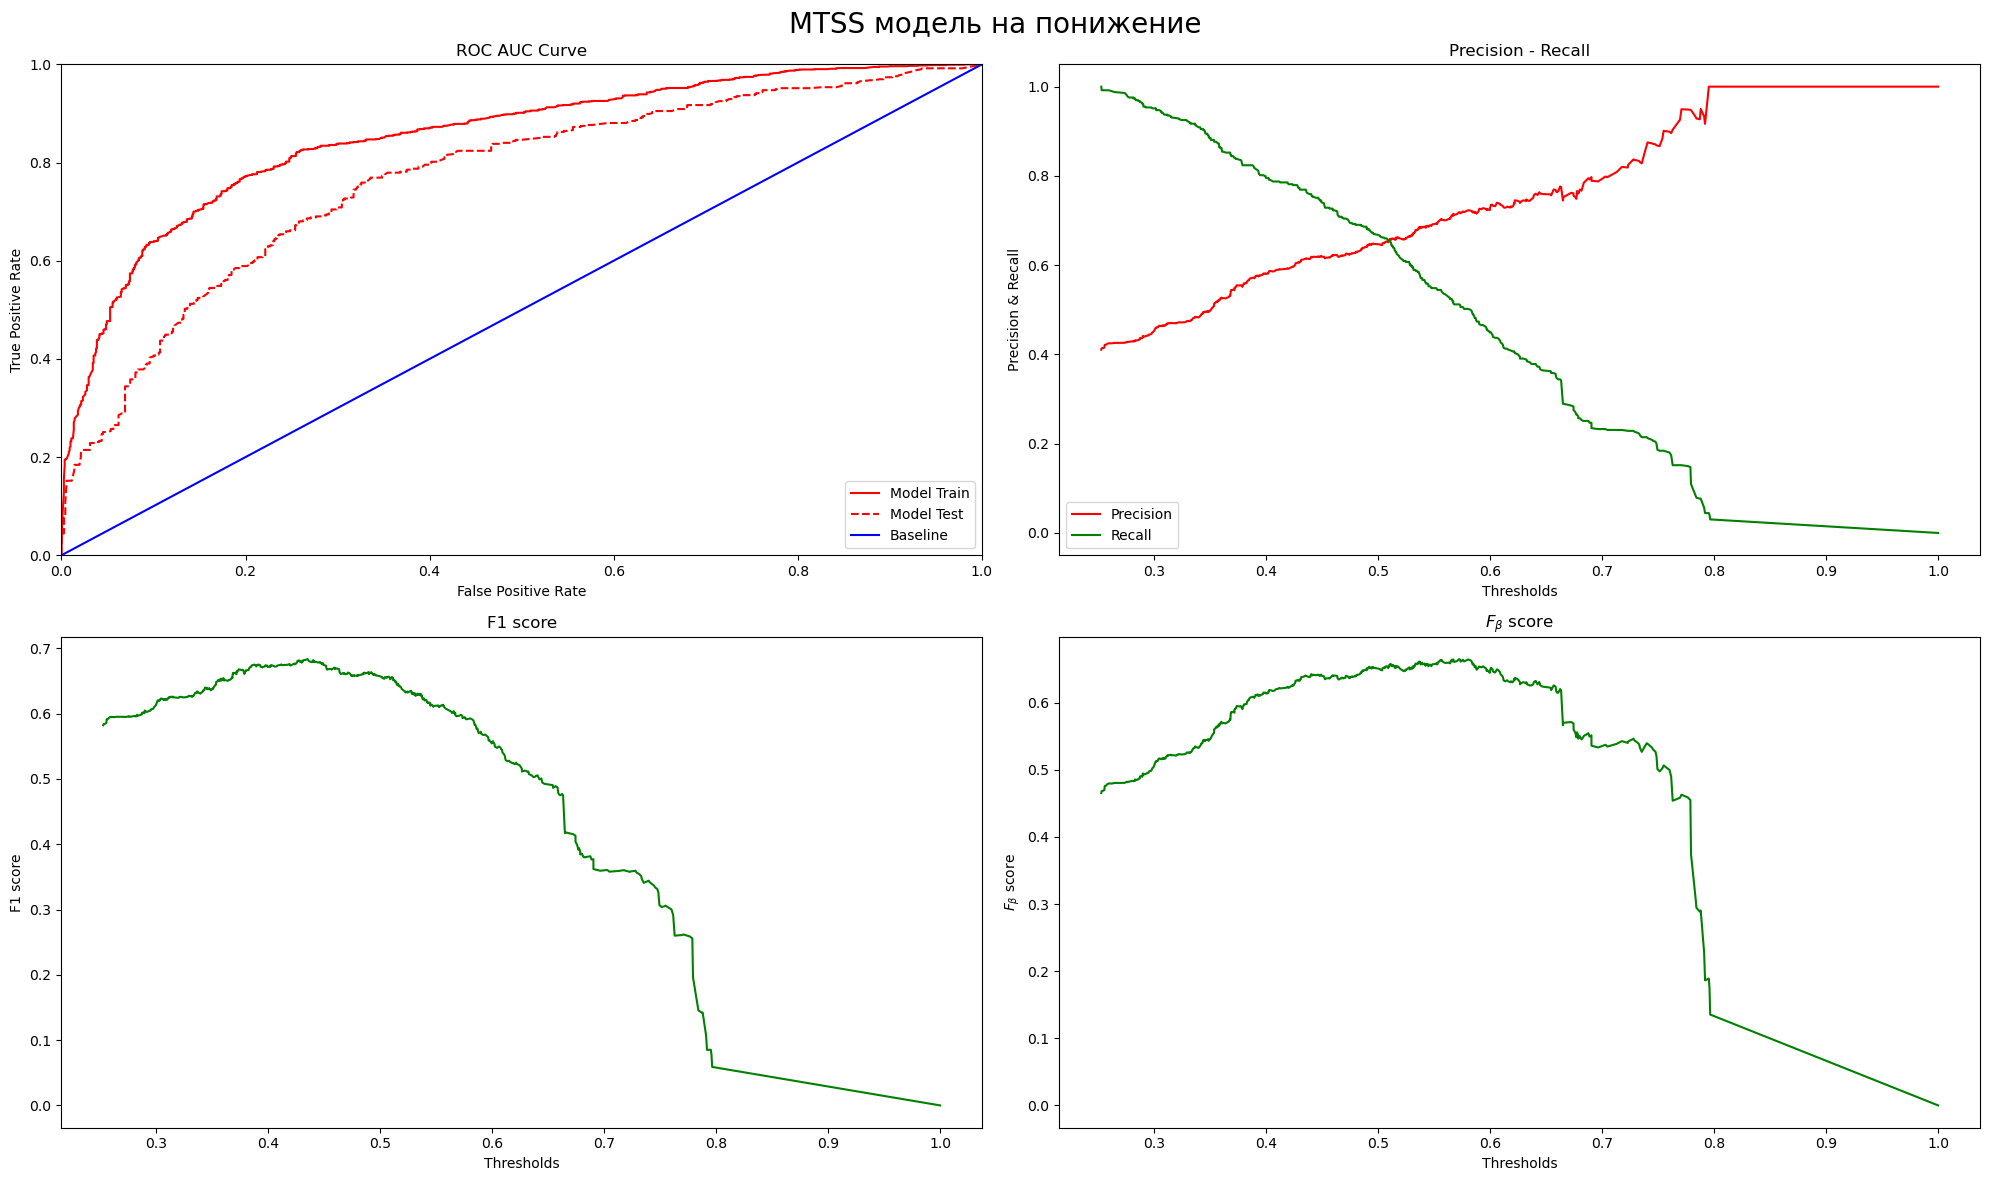

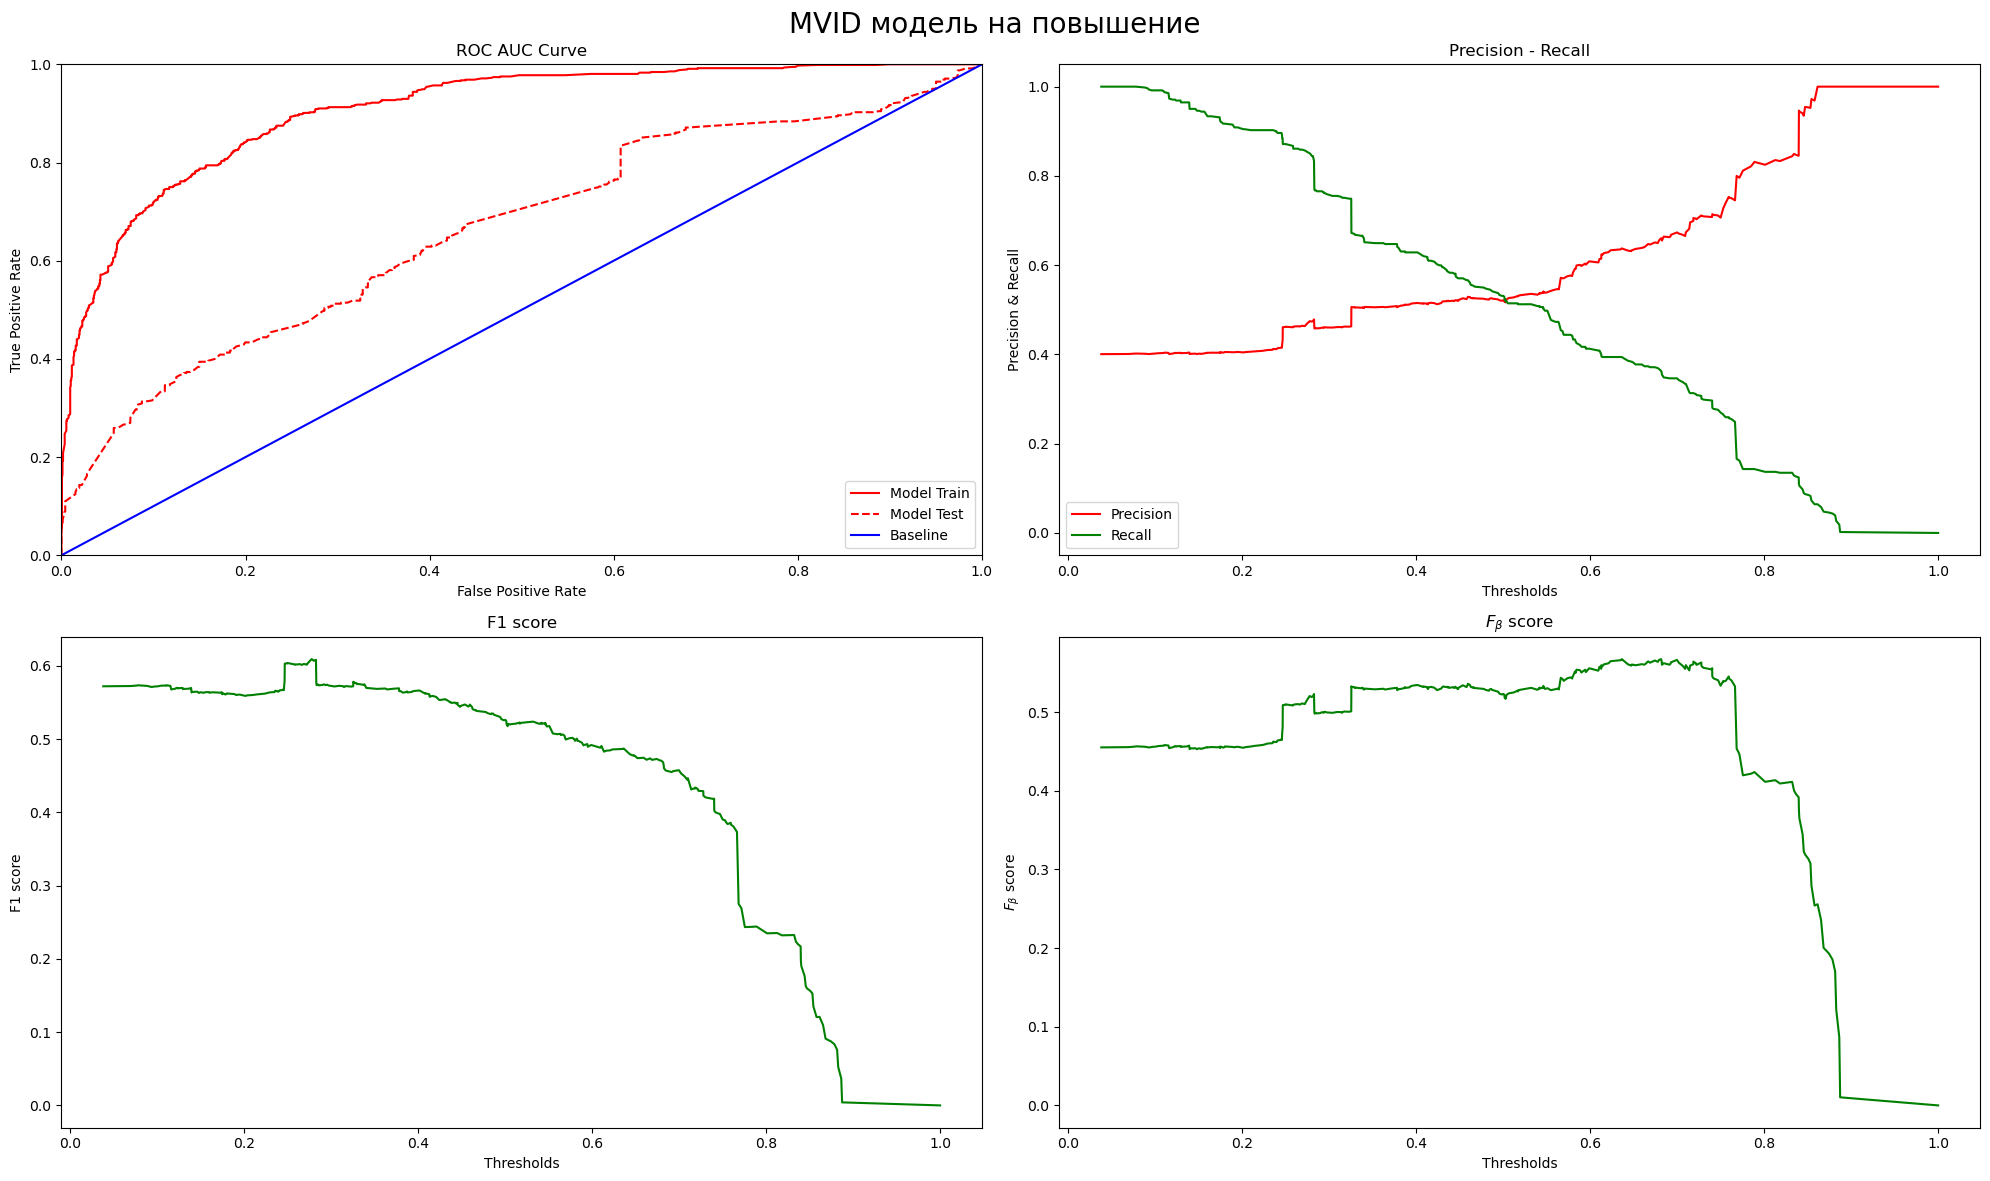

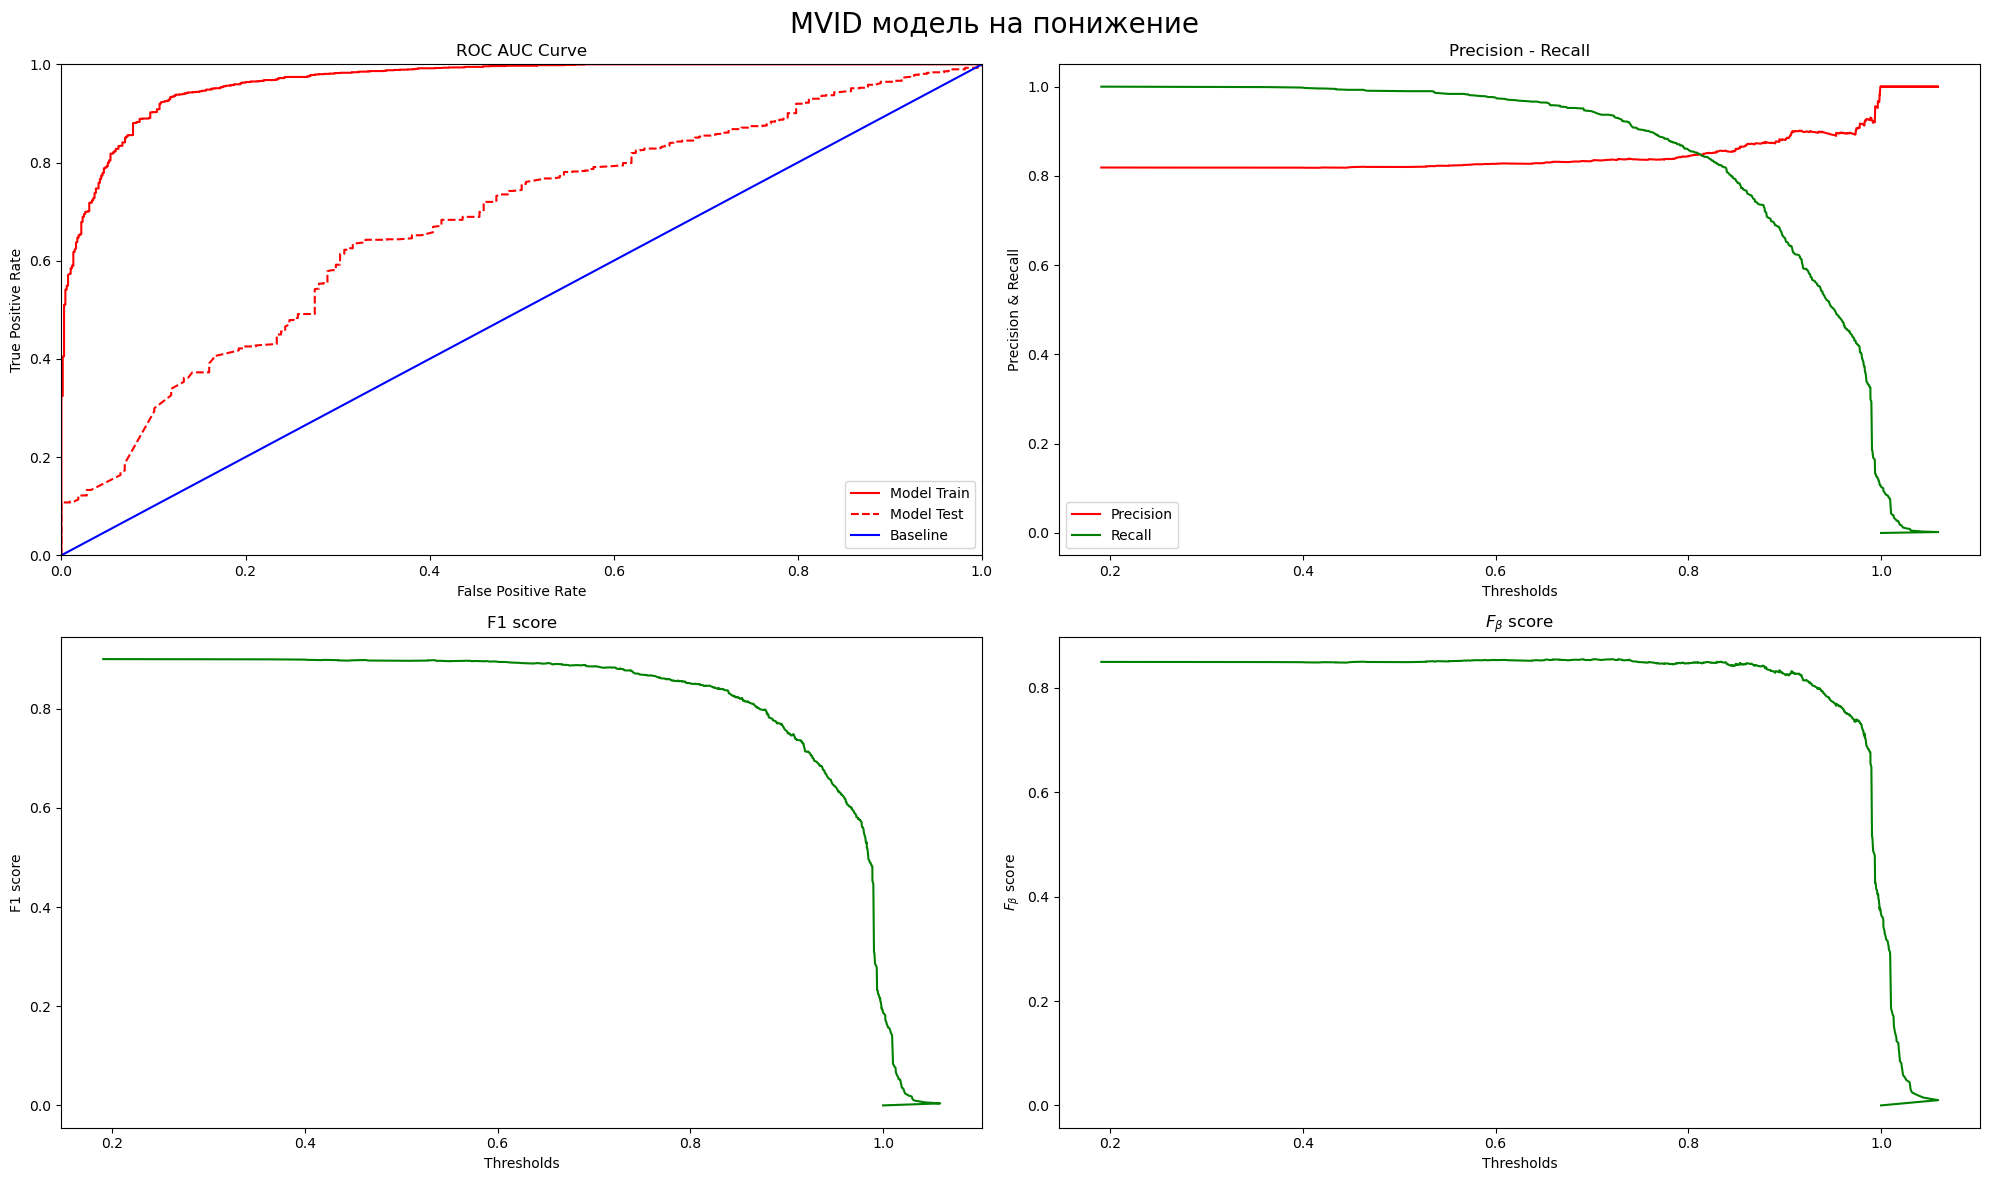

In [21]:
def plot_metrics(model, X_train, X_test, y_train, y_test, suptitle):
    pred_proba_train = model.predict(X_train)
    pred_proba_test = model.predict(X_test)
        
    fpr_train, tpr_train, _ = roc_curve(y_train, pred_proba_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, pred_proba_test)
    
    precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, pred_proba_test)      
    f1 = 2 * precision_test * recall_test  / (precision_test + recall_test)
    
    # Берем beta меньше нуля, тем самым ставя точность приоритетнее полноты
    beta = 0.5
    f_beta = (1 + beta**2) * precision_test * recall_test  / (beta**2 * precision_test + recall_test)
    
    fig, axes = plt.subplots(2, 2, figsize = (20, 12))

    fig.suptitle(suptitle, fontsize=20)
    
    axes[0][0].plot(fpr_train, tpr_train, 'r', label = 'Model Train')
    axes[0][0].plot(fpr_test, tpr_test, 'r--', label = 'Model Test')
    axes[0][0].plot([0, 1], [0, 1], 'b', label = 'Baseline')
    axes[0][0].set_xlim([0.0, 1.0])
    axes[0][0].set_ylim([0.0, 1.0])
    axes[0][0].set_xlabel('False Positive Rate')
    axes[0][0].set_ylabel('True Positive Rate')
    axes[0][0].legend(loc = "lower right")
    axes[0][0].set_title('ROC AUC Curve')
    
    
    axes[0][1].plot(np.append(thresholds_test, 1.0), precision_test, 'r', label = 'Precision')
    axes[0][1].plot(np.append(thresholds_test, 1.0), recall_test, 'g', label = 'Recall')
    axes[0][1].set_xlabel('Thresholds')
    axes[0][1].set_ylabel('Precision & Recall')
    axes[0][1].legend(loc = "lower left")
    axes[0][1].set_title('Precision - Recall')
    
    
    axes[1][0].plot(np.append(thresholds_test, 1.0), f1, 'g')
    axes[1][0].set_xlabel('Thresholds')
    axes[1][0].set_ylabel('F1 score')
    axes[1][0].set_title('F1 score')
    
    axes[1][1].plot(np.append(thresholds_test, 1.0), f_beta, 'g')
    axes[1][1].set_xlabel('Thresholds')
    axes[1][1].set_ylabel(r'$F_{\beta}$' + ' score')
    axes[1][1].set_title(r'$F_{\beta}$' + ' score')

    plt.tight_layout()
    plt.show()


for ticker, p in best_models_p.items():
    window_size, min_threshold, max_threshold = p
    min_p = (ticker, window_size, 'min', min_threshold)
    max_p = (ticker, window_size, 'max', max_threshold)
    min_model = models[min_p]
    max_model = models[max_p]

    min_X_train, min_X_test, min_y_train, min_y_test = splits[min_p]
    max_X_train, max_X_test, max_y_train, max_y_test = splits[max_p]

    plot_metrics(
        max_model,
        max_X_train, max_X_test,
        max_y_train, max_y_test,
        f"{ticker} модель на повышение"
    )
    plot_metrics(
        min_model,
        min_X_train, min_X_test,
        min_y_train, min_y_test,
        f"{ticker} модель на понижение"
    )